In [34]:
import numpy as np
import pymongo
import pandas as pd
from scipy.stats import ks_2samp, describe, skew, gaussian_kde
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import copy
import seaborn as sns
from scipy import stats
from ast import literal_eval
import random


import pdb

pd.options.display.max_columns = 500

## Get data, divide the area estimates into own rows

In [26]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['lyrebird_fake']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating fake set')
df = df.drop(columns=['_id'])

#explode data into rows
df_explode = df.explode('cross_sect_est')

#get index column
indices = []
for _, row in df.iterrows():
    areas = row['cross_sect_est']
    indices += list(range(0, len(areas)))
    
df_explode['area_index'] = indices
df_explode['dataset'] = 'fake'

#fix speaker labels
new_speaker_ids = []
for _, row in df_explode.iterrows():
    if "obama" in row.filepath:
        new_speaker_ids.append('Obama')
    else:
        new_speaker_ids.append('Trump')

df_explode['speaker_id'] = new_speaker_ids

#move to unique name
df_fake = df_explode

Creating fake set


In [27]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['lyrebird_true']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating true set')
df = df.drop(columns=['_id'])

#explode data into rows
df_explode = df.explode('cross_sect_est')

#get index column
indices = []
for _, row in df.iterrows():
    areas = row['cross_sect_est']
    indices += list(range(0, len(areas)))
    
df_explode['area_index'] = indices
df_explode['dataset'] = 'true'

#fix speaker labels
new_speaker_ids = []
for _, row in df_explode.iterrows():
    if "obama" in row.filepath:
        new_speaker_ids.append('Obama')
    else:
        new_speaker_ids.append('Trump')

df_explode['speaker_id'] = new_speaker_ids

#move to unique name
df_true = df_explode

Creating true set


In [29]:
#combine
df_explode = pd.concat([df_true, df_fake], ignore_index=True)

In [5]:
df.columns

Index(['cross_sect_est', 'label', 'filepath', 'speaker_id', 'start_bigram',
       'end_bigram', 'window_start', 'window_end', 'window_index', 'sex',
       'area_index', 'dataset'],
      dtype='object')

## Now, compare sets of feature tuples

<ipython-input-6-f1710321da18>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,10))


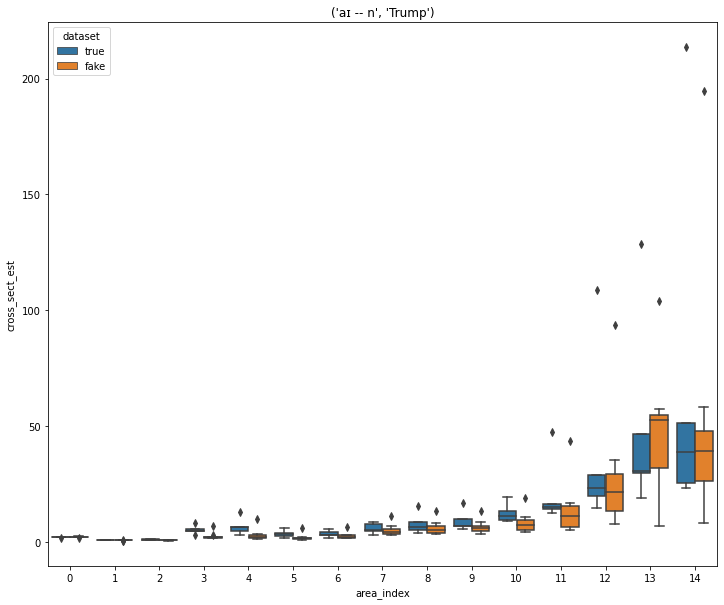

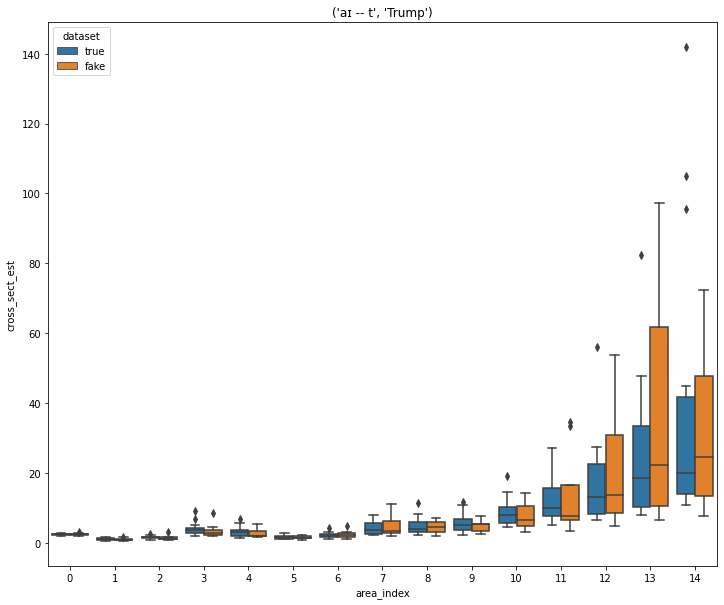

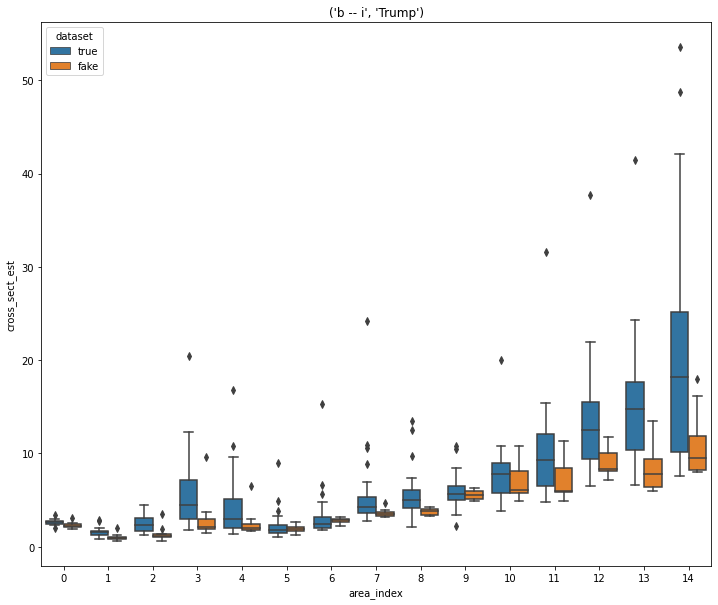

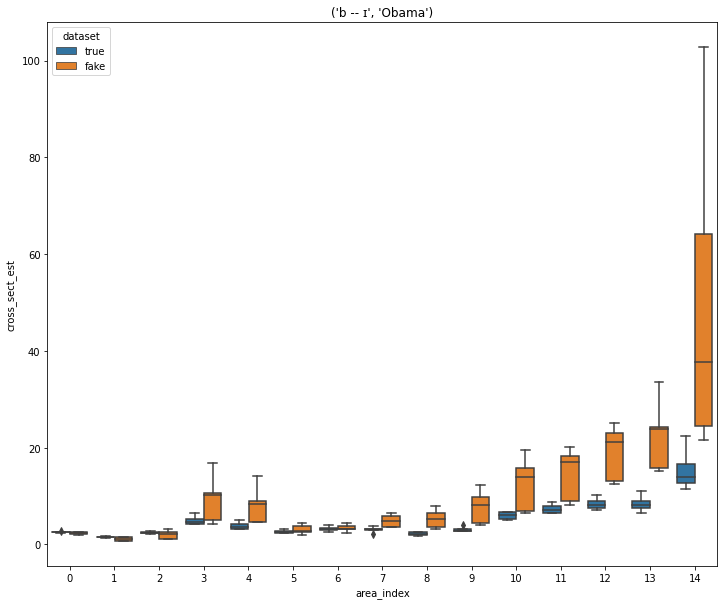

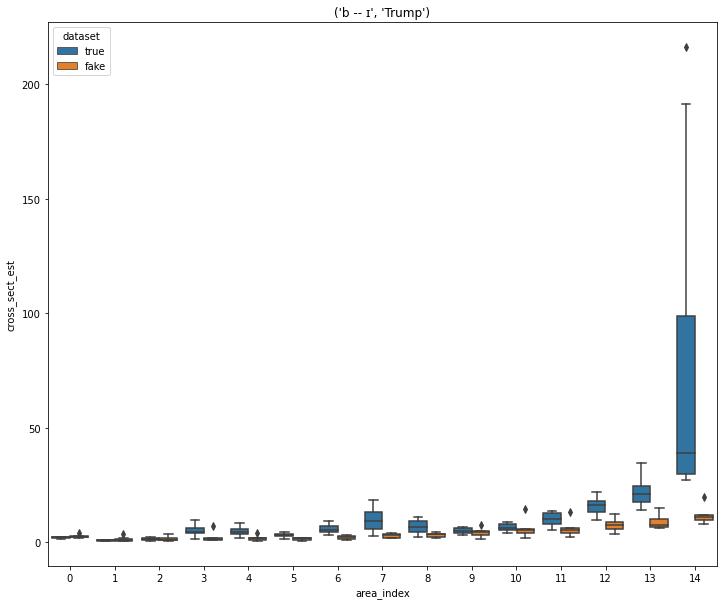

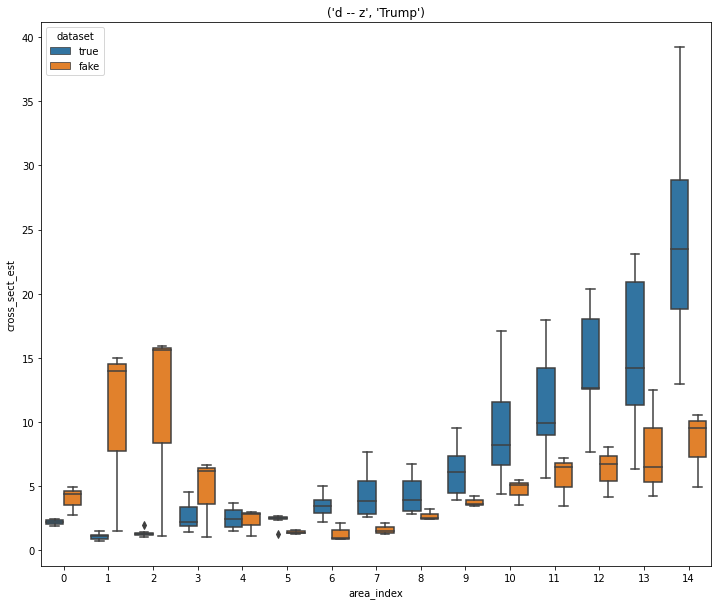

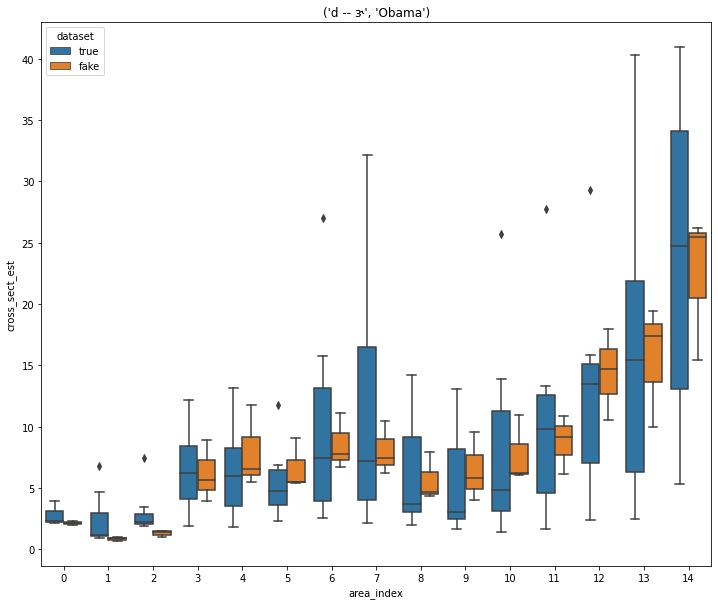

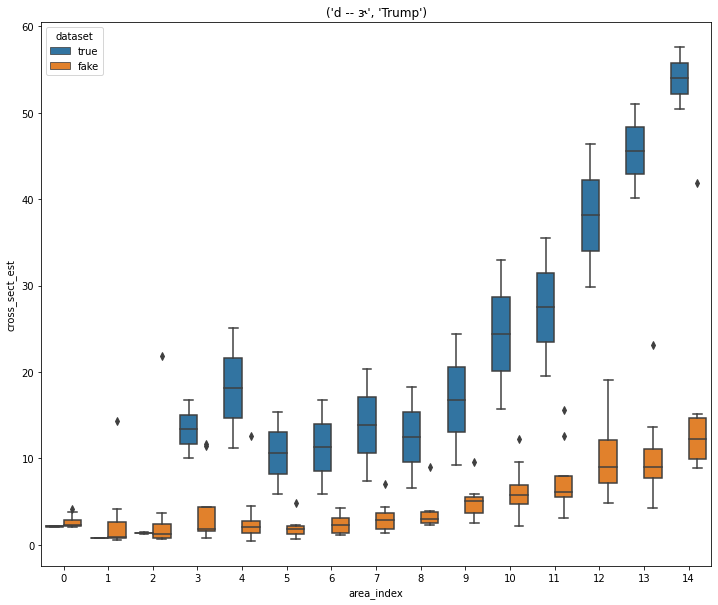

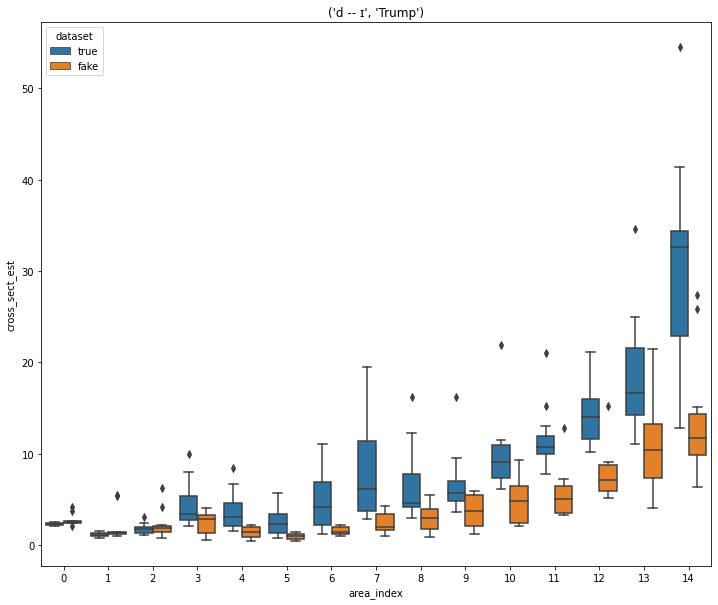

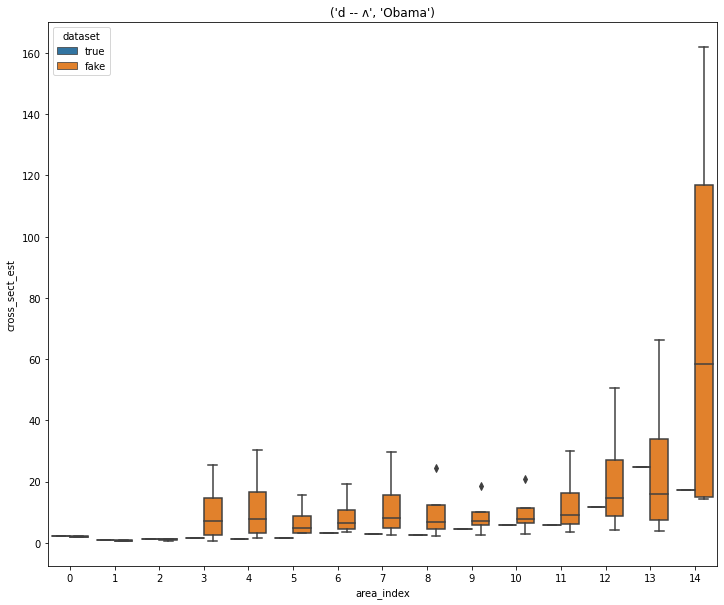

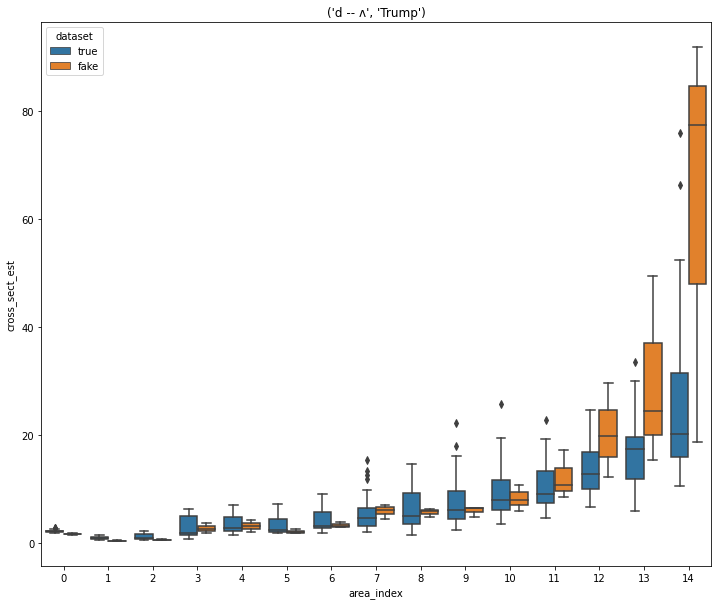

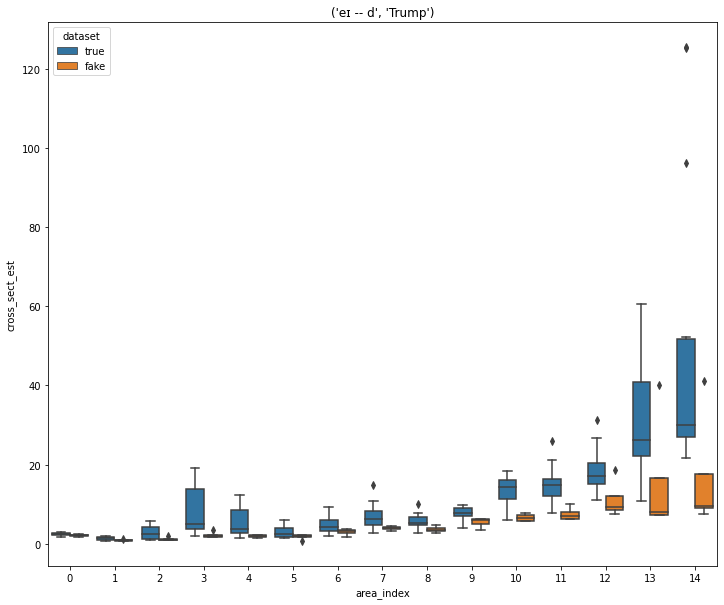

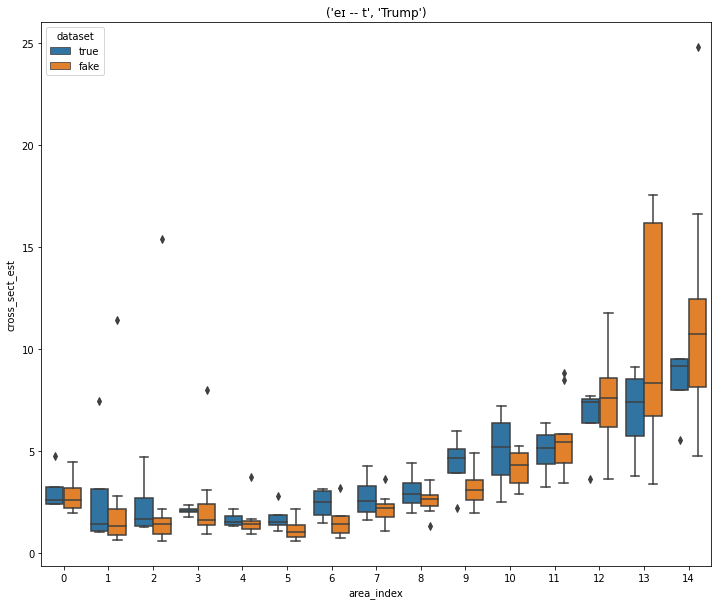

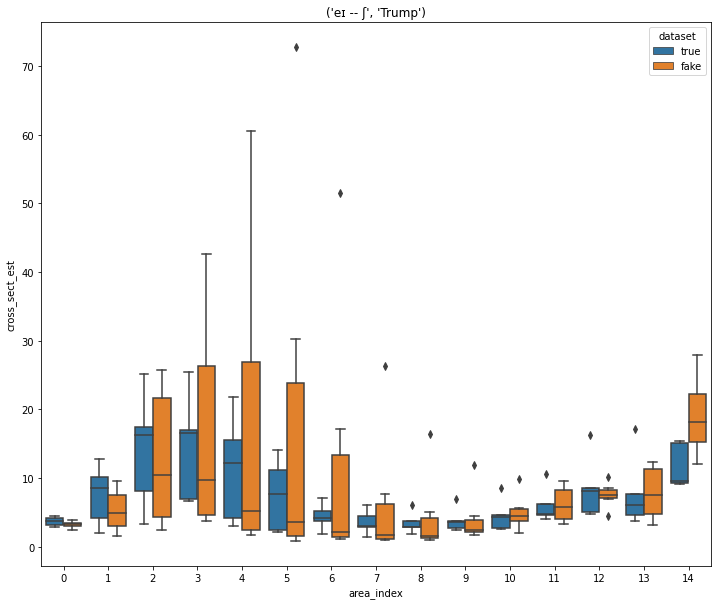

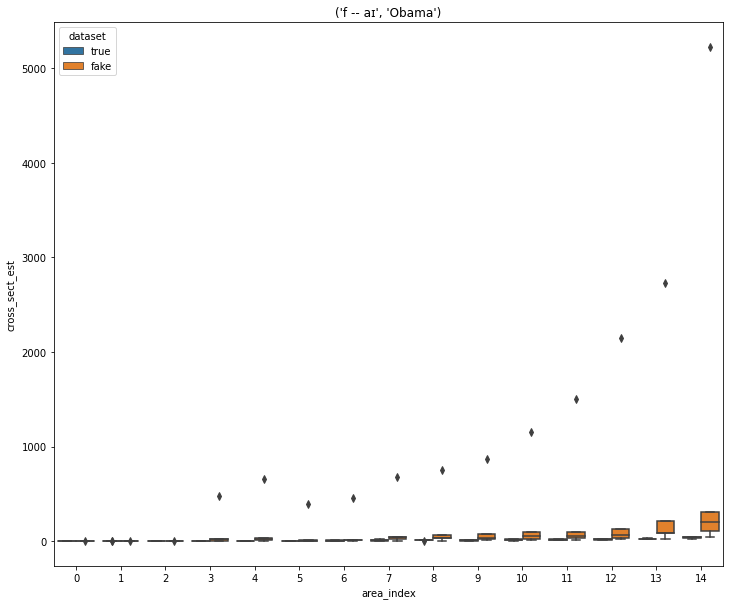

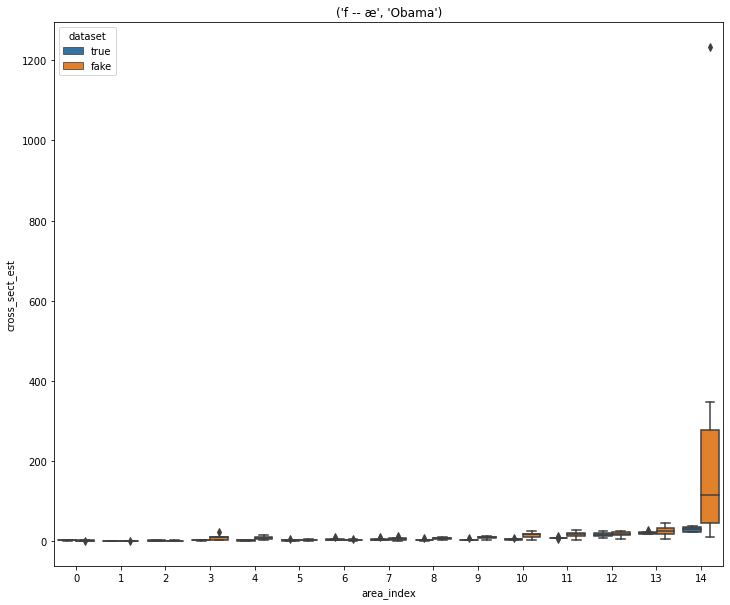

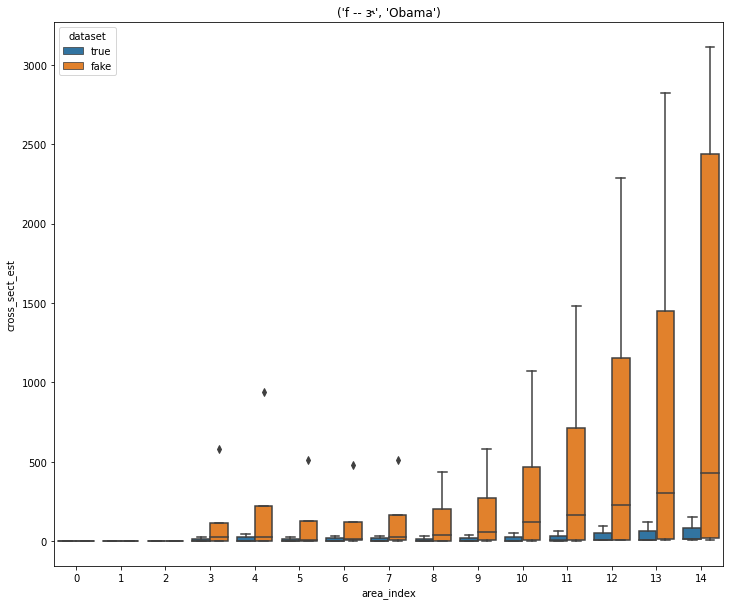

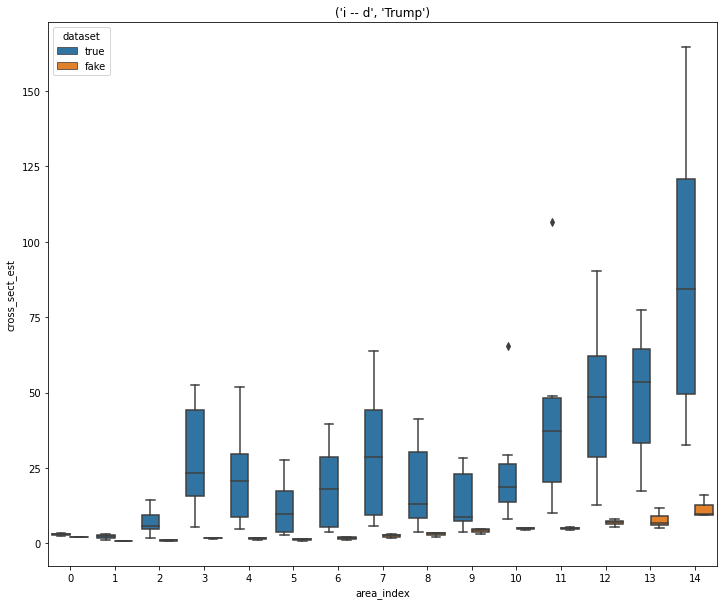

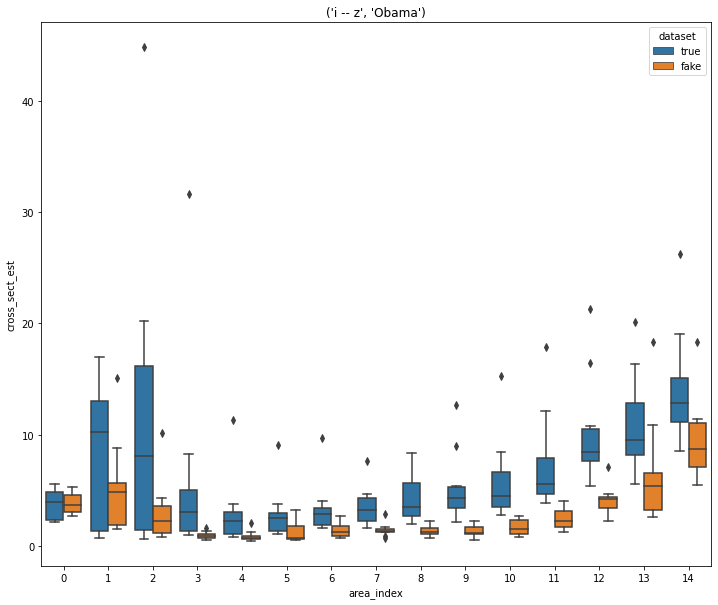

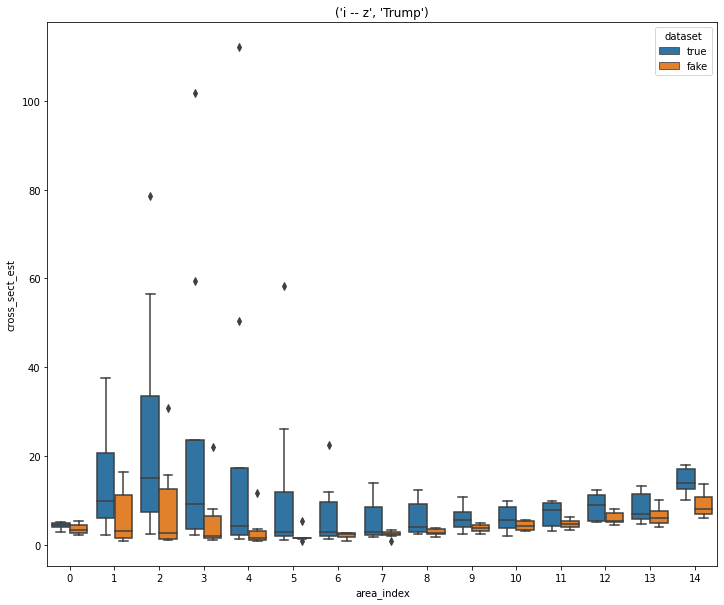

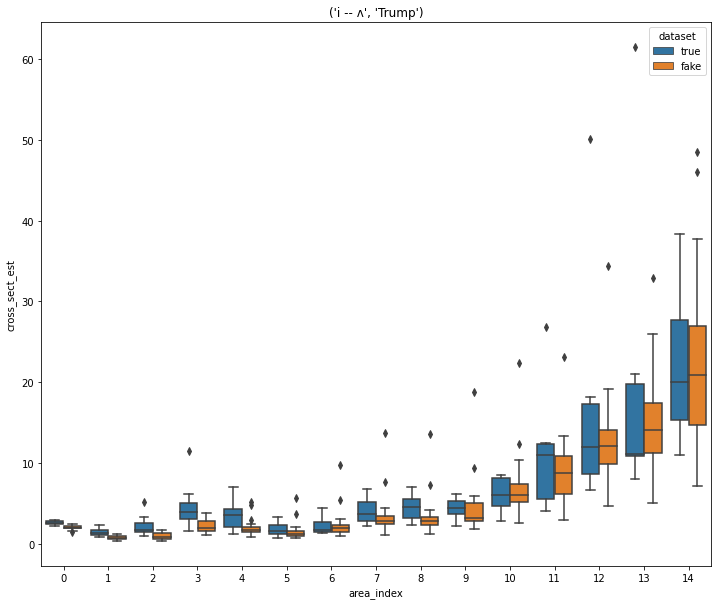

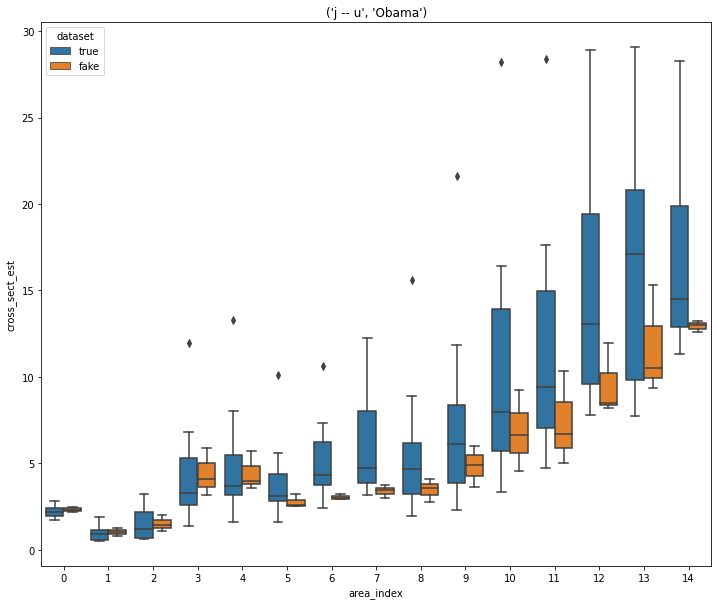

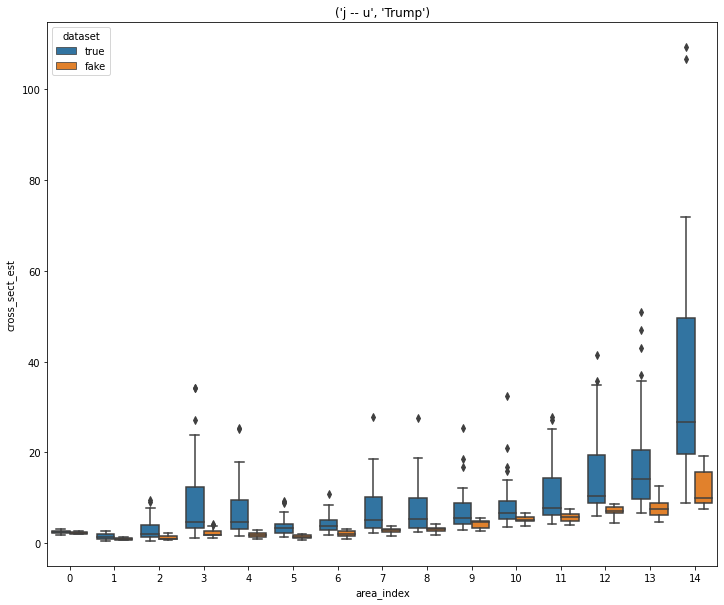

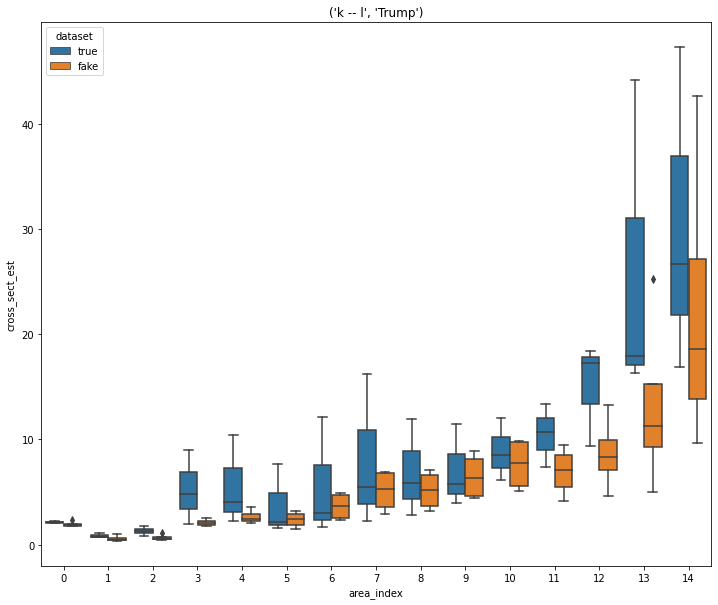

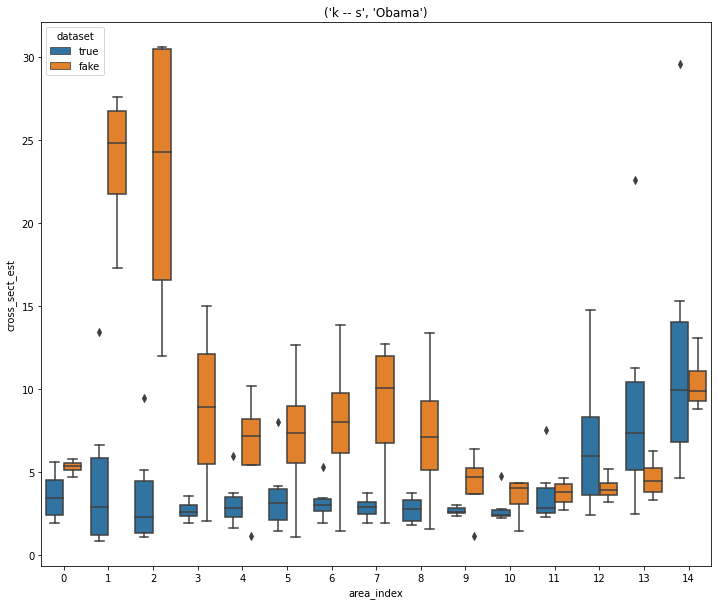

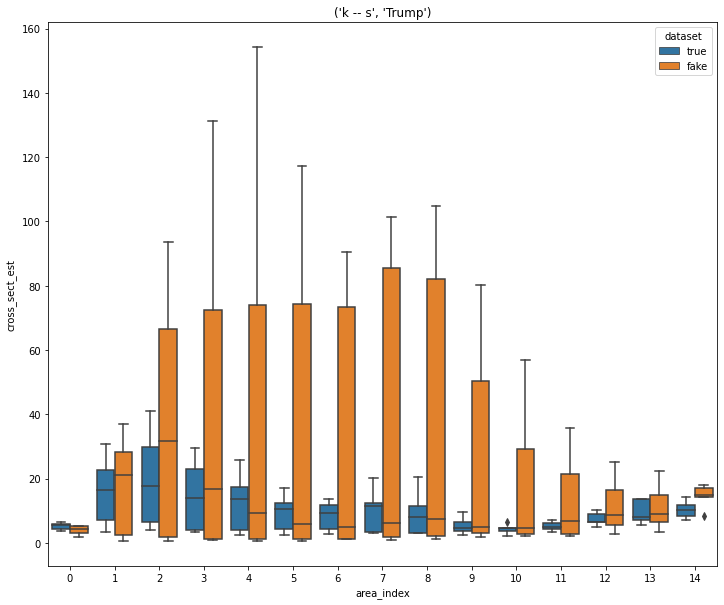

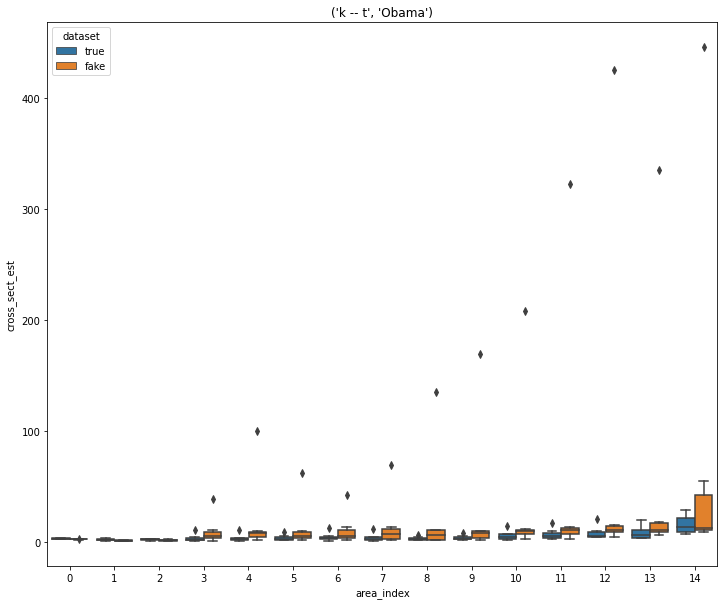

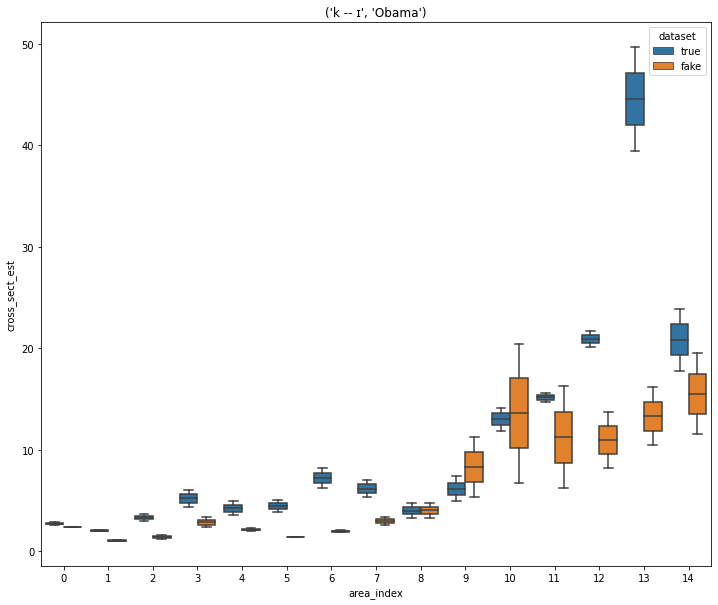

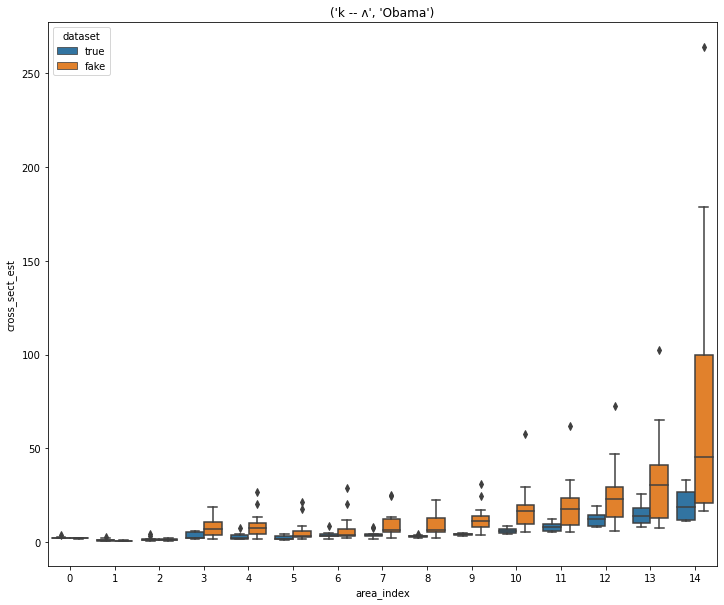

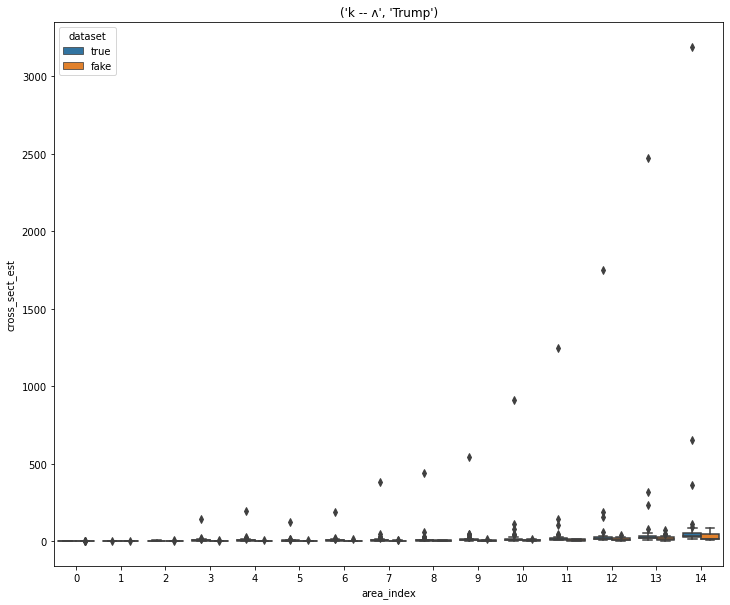

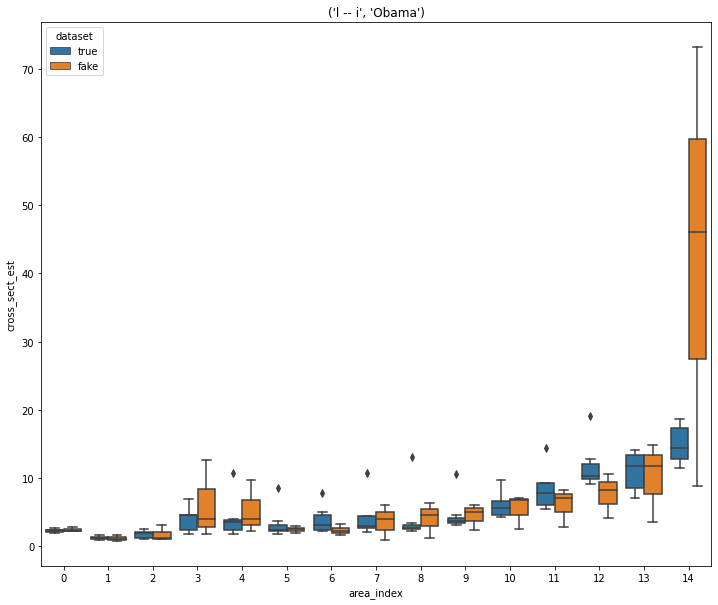

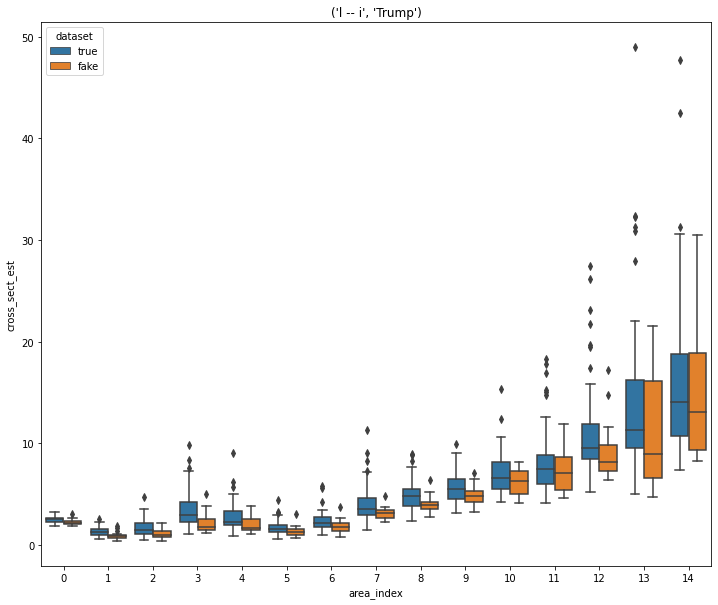

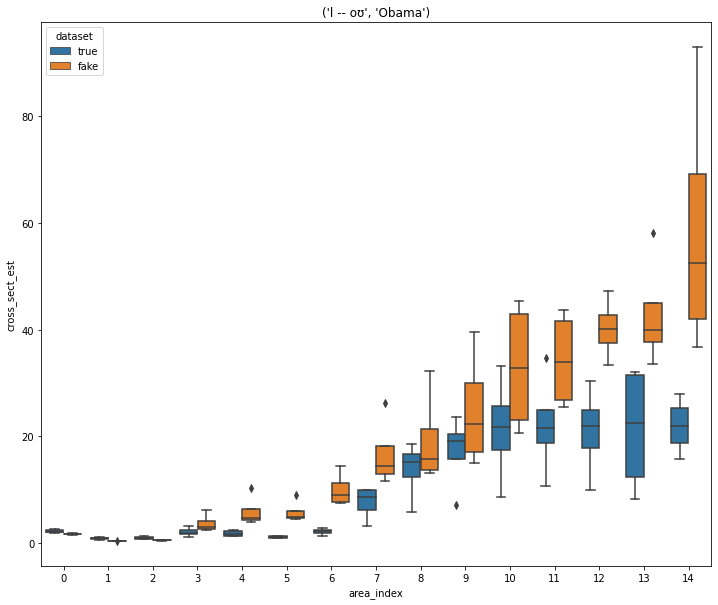

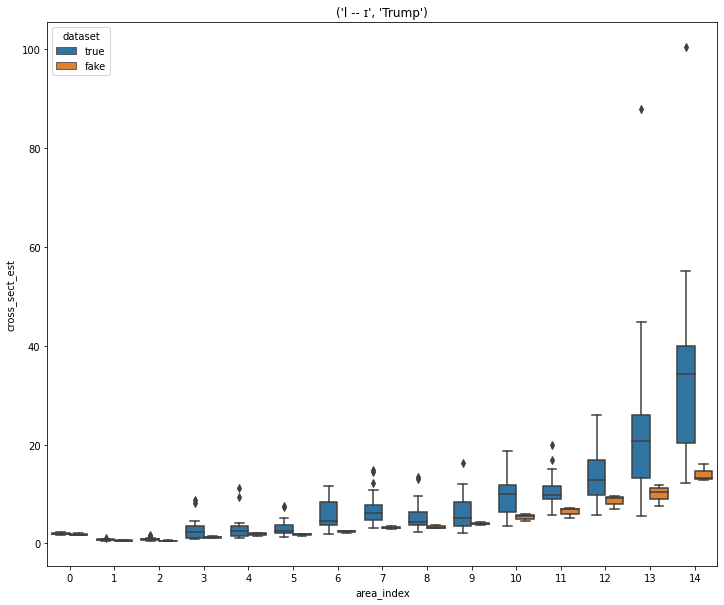

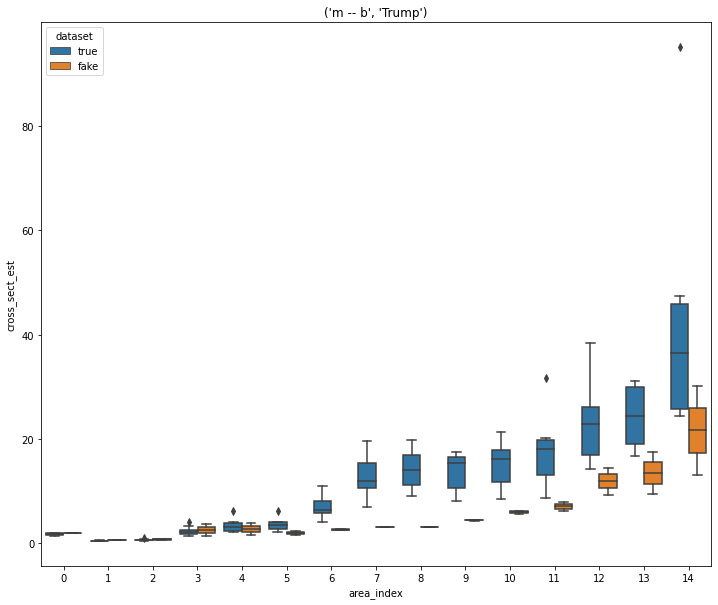

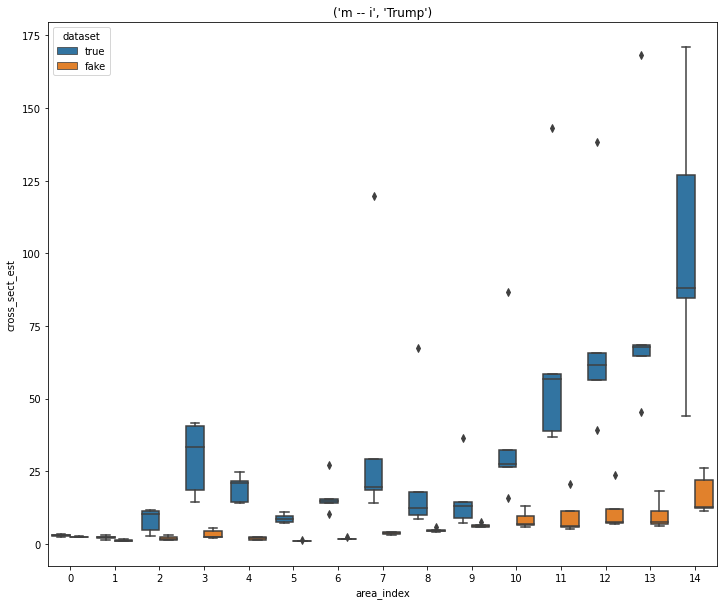

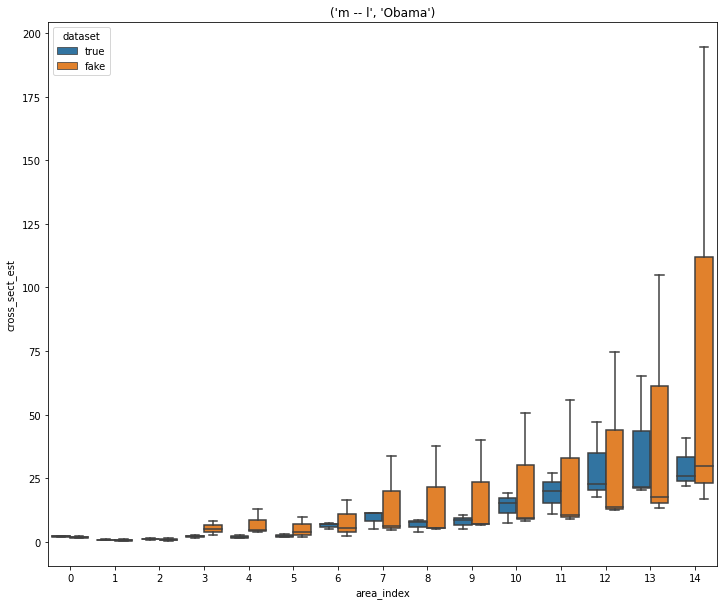

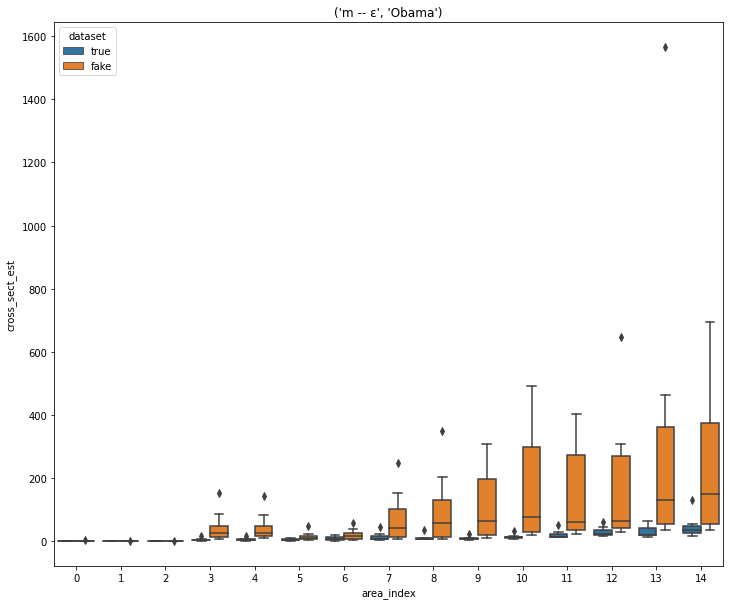

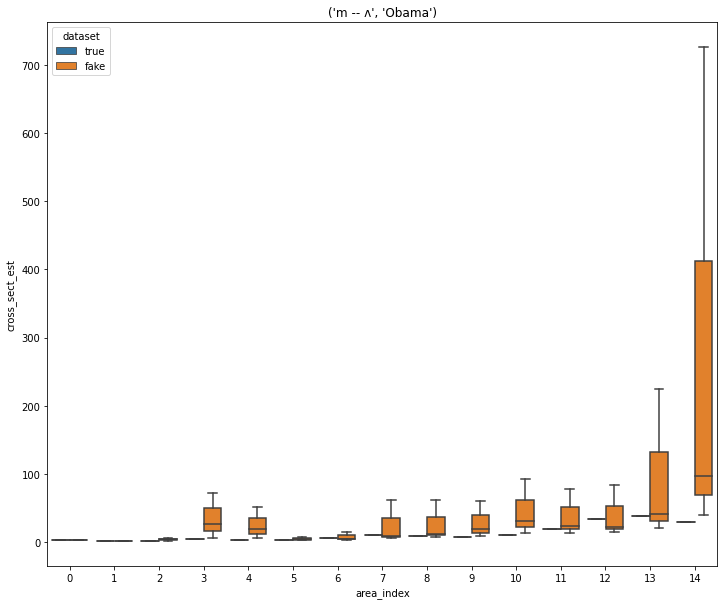

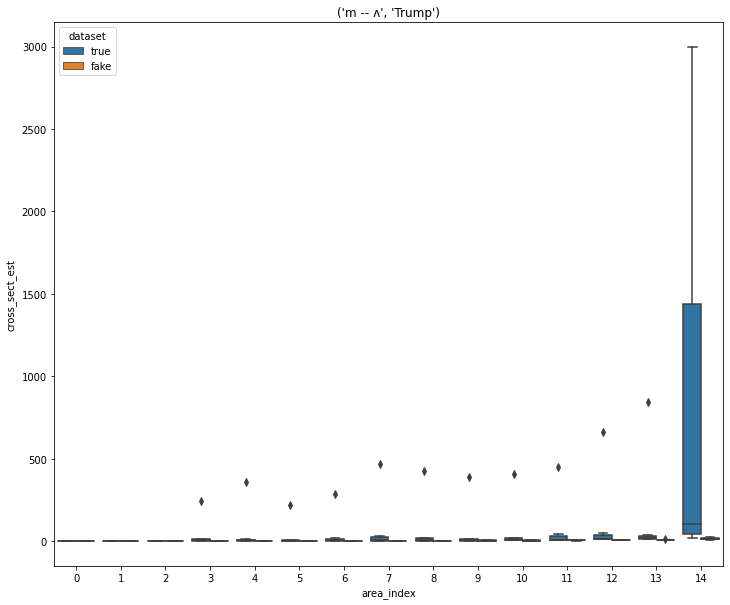

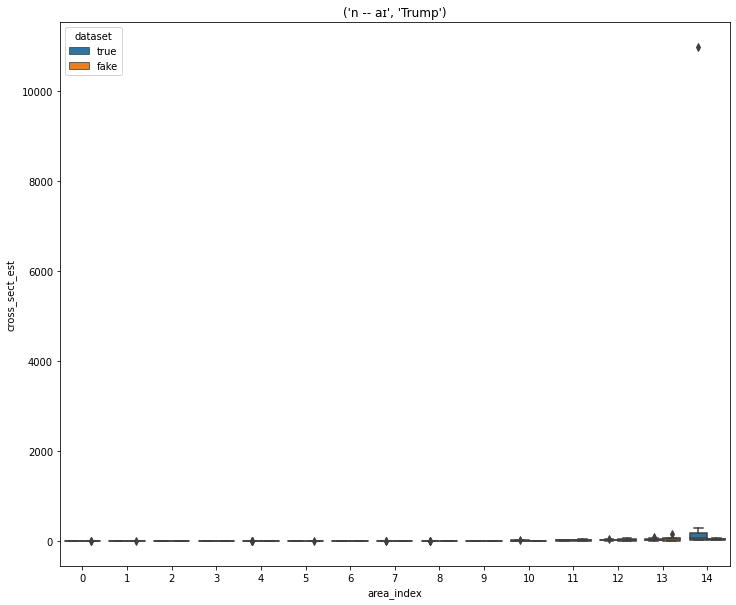

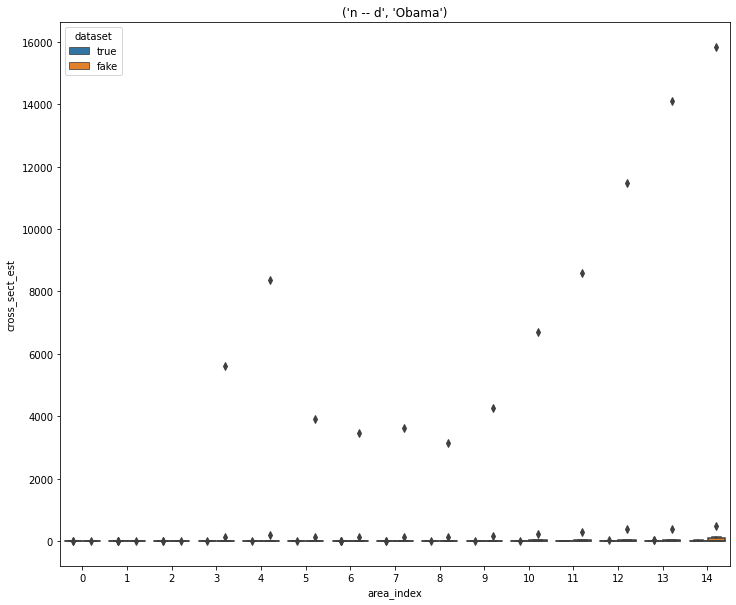

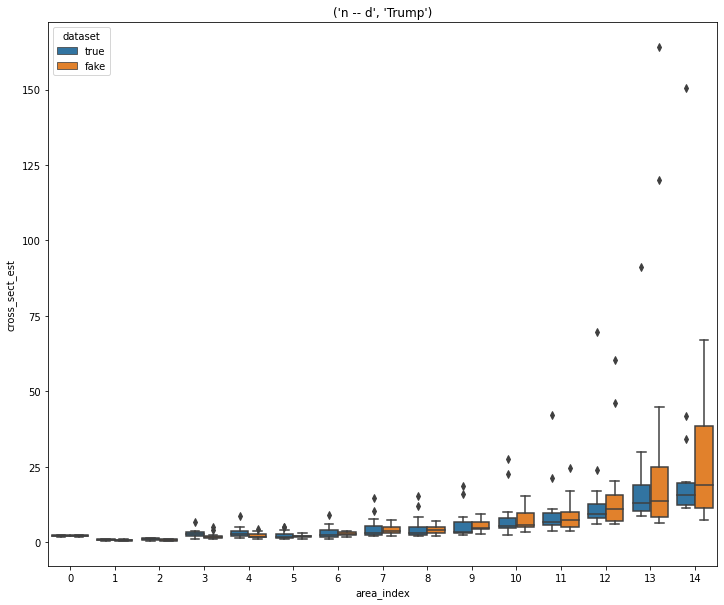

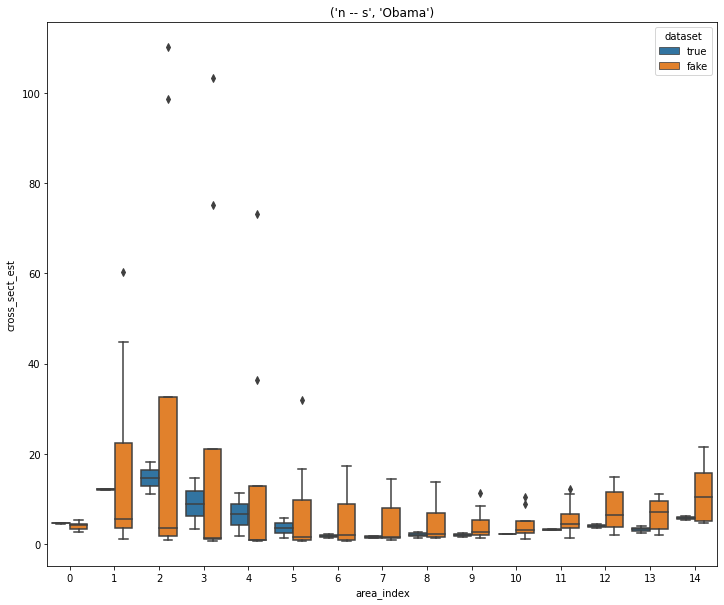

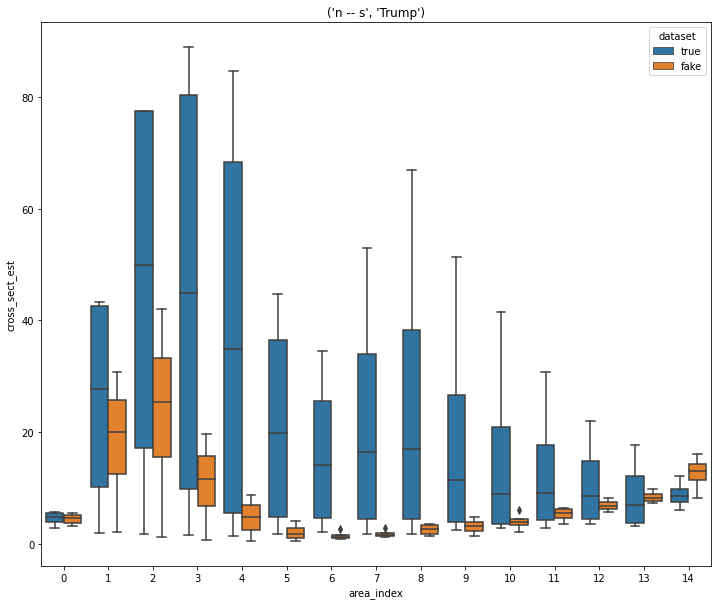

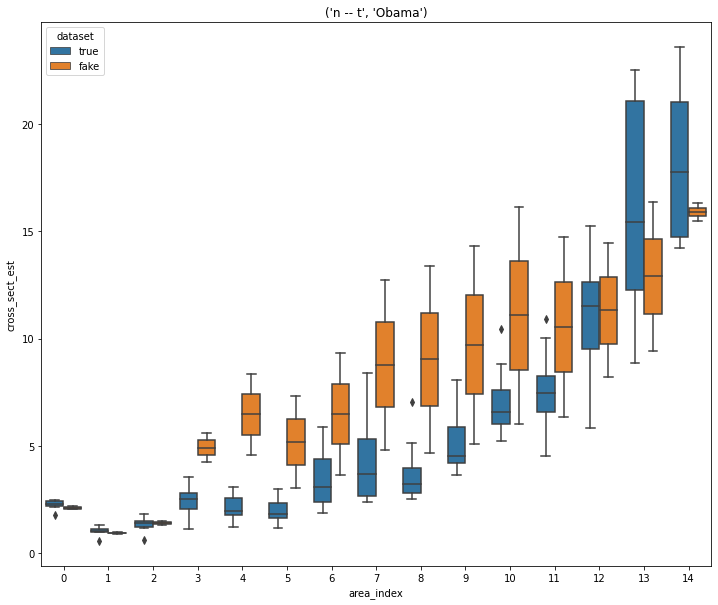

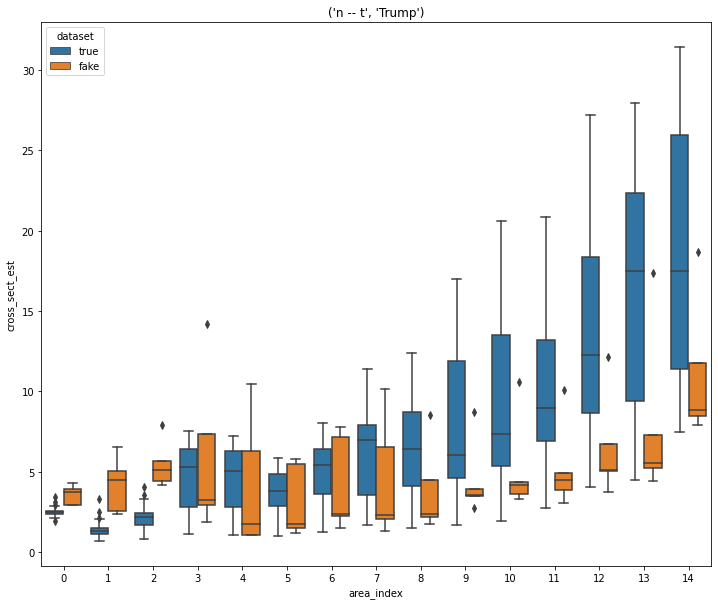

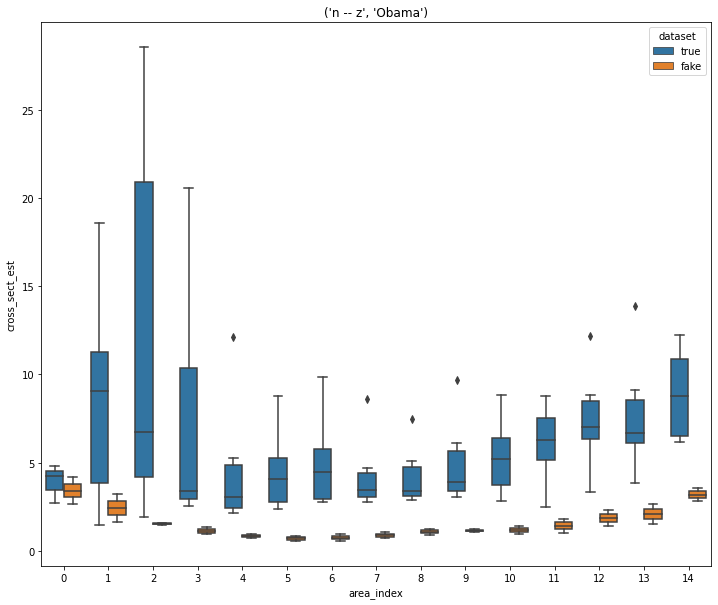

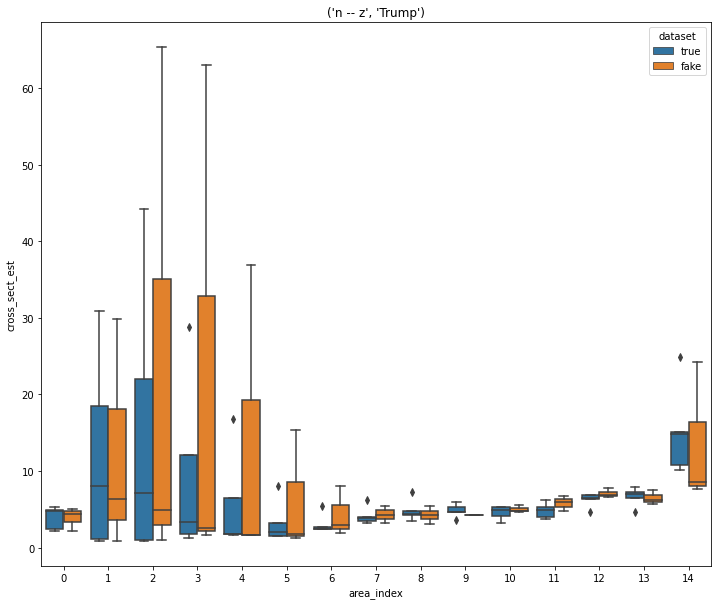

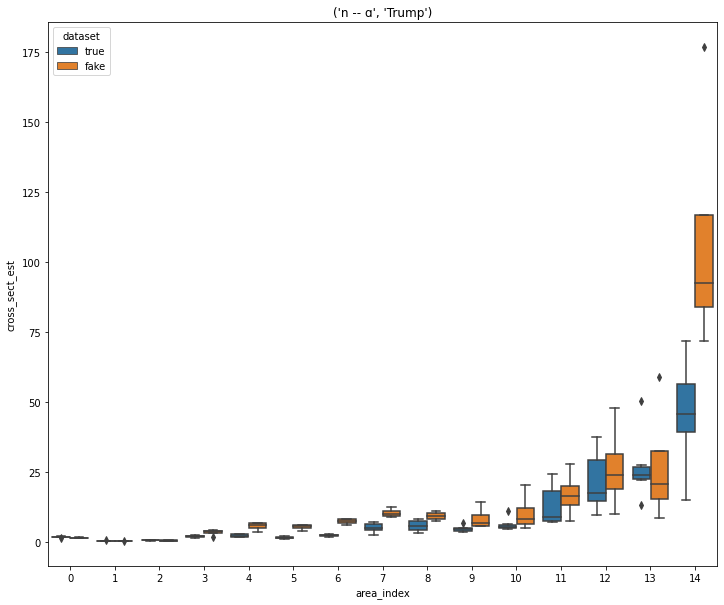

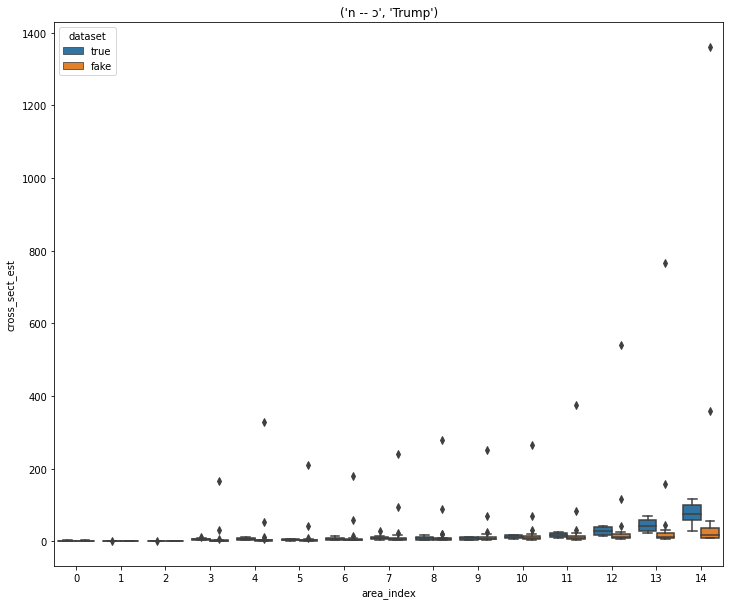

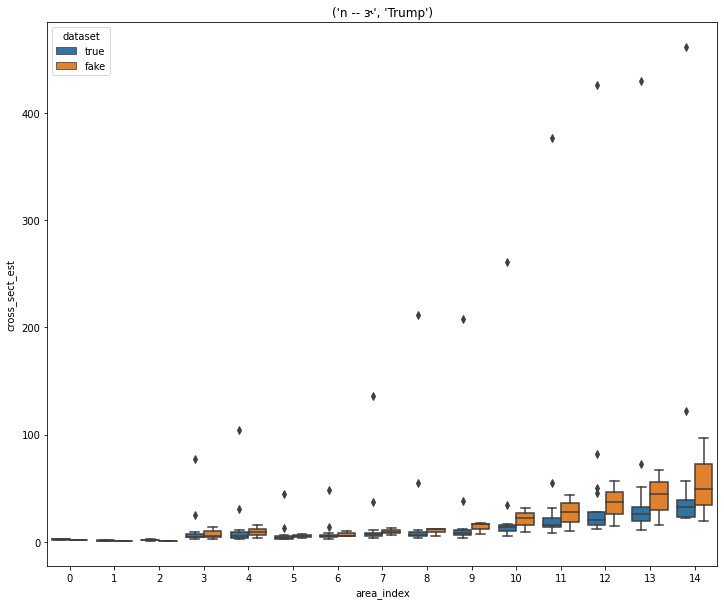

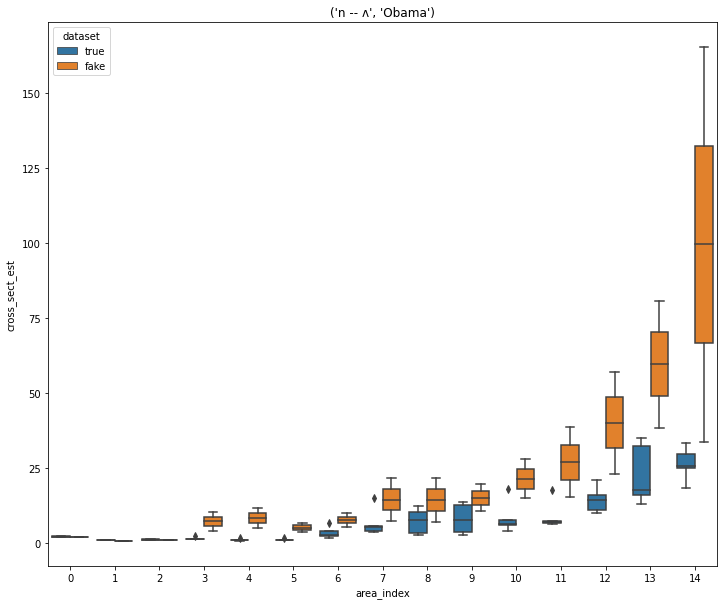

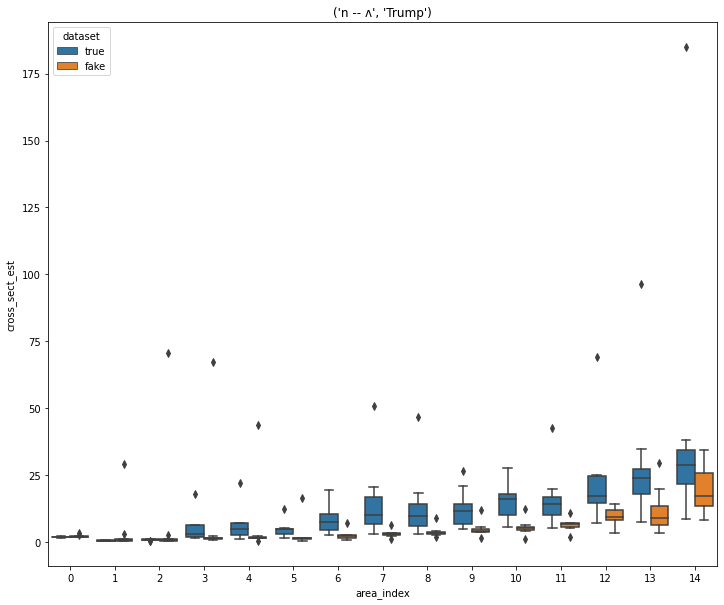

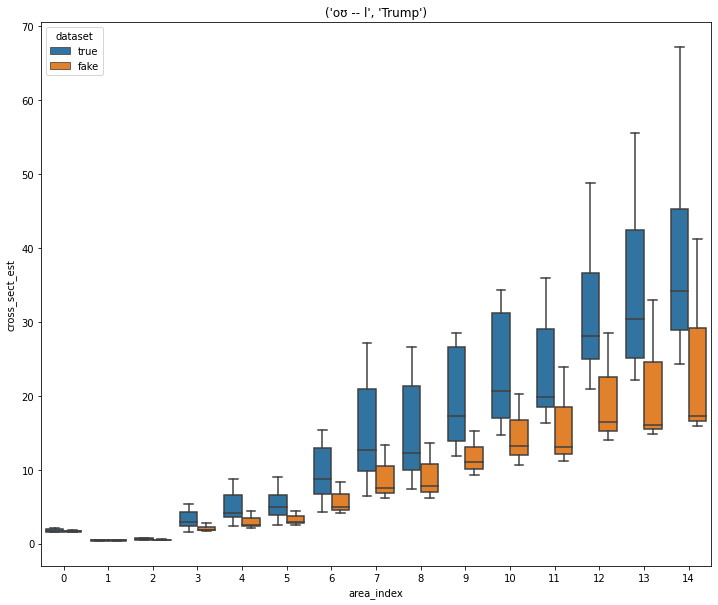

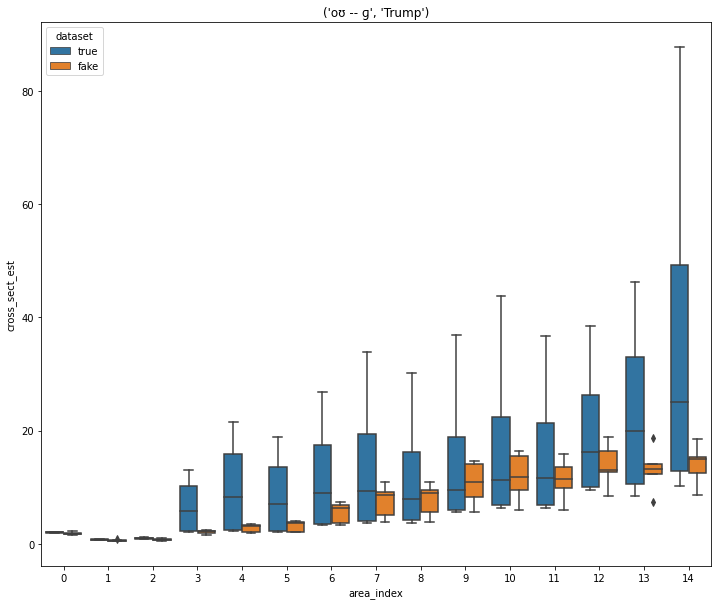

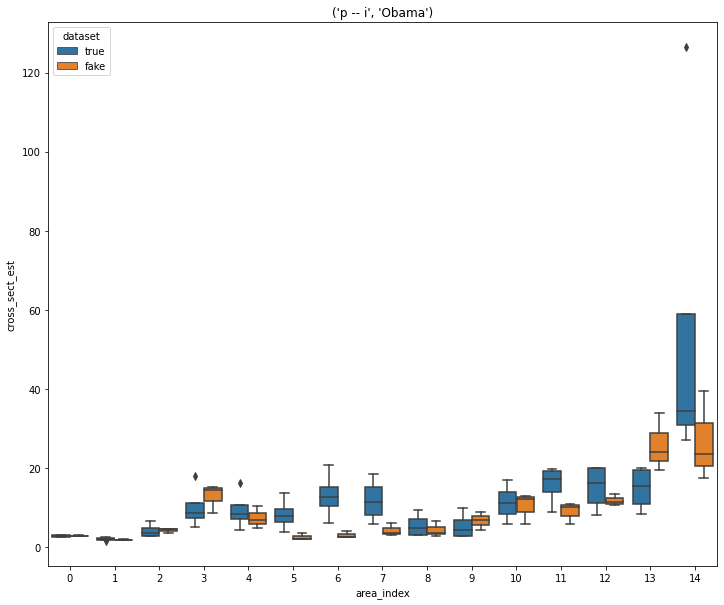

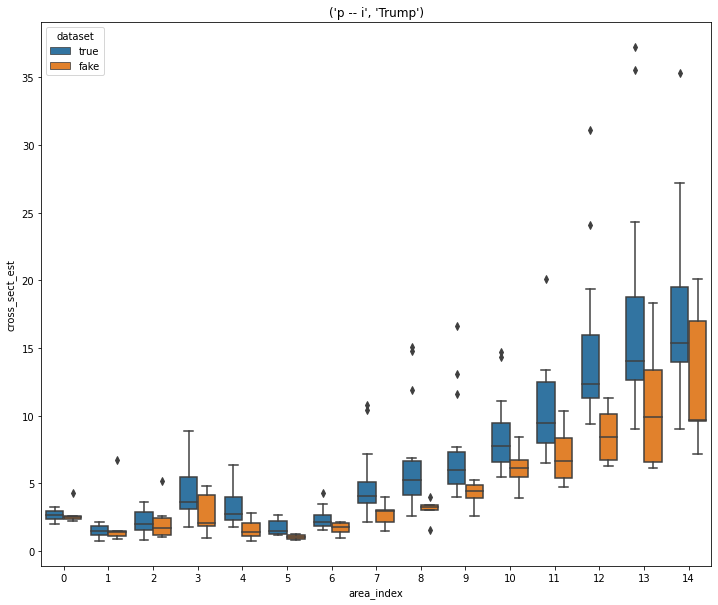

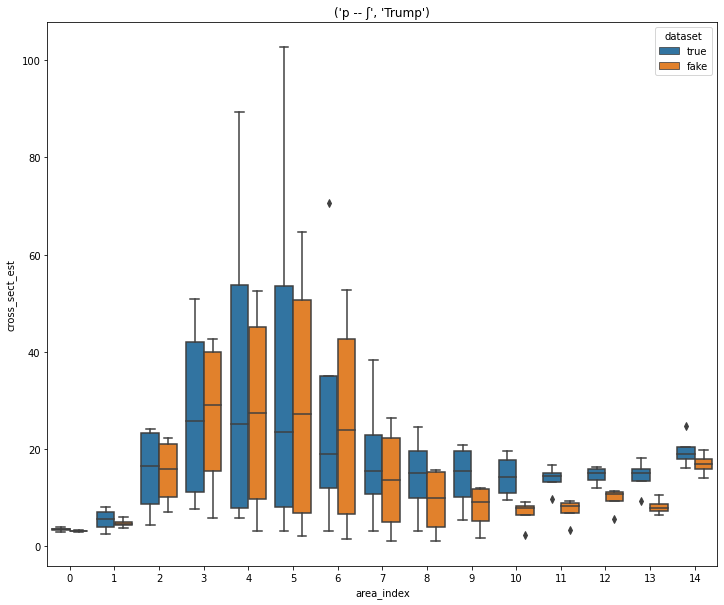

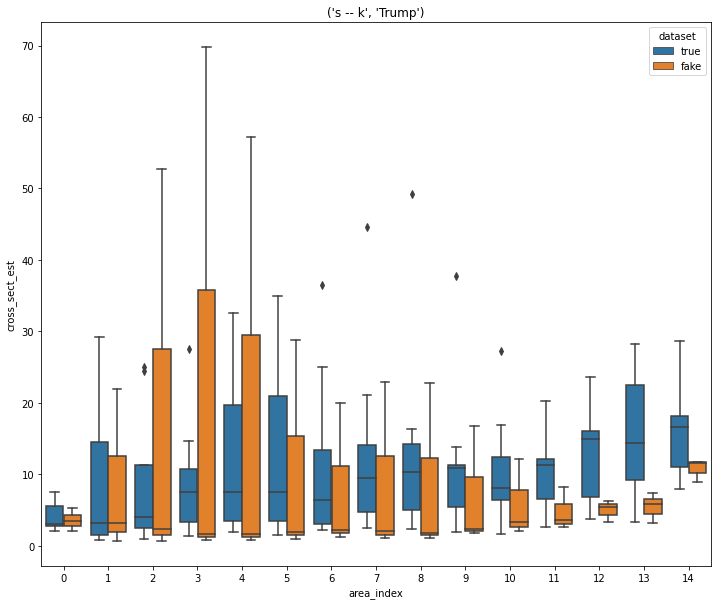

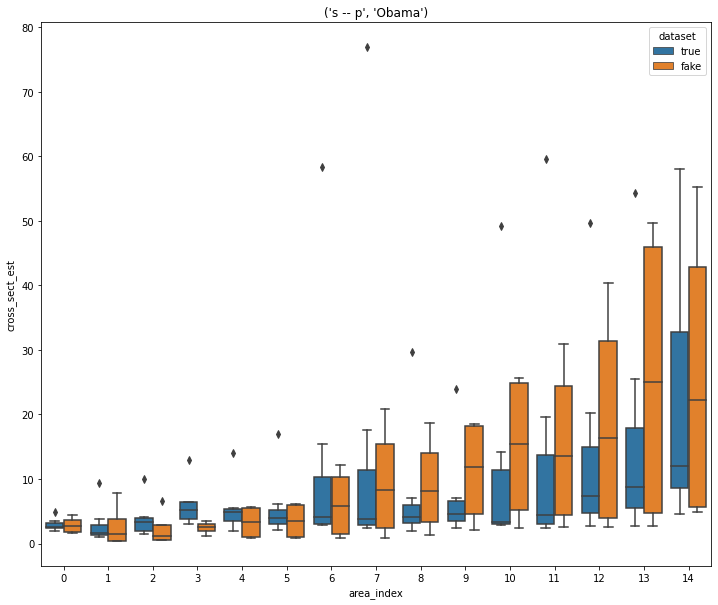

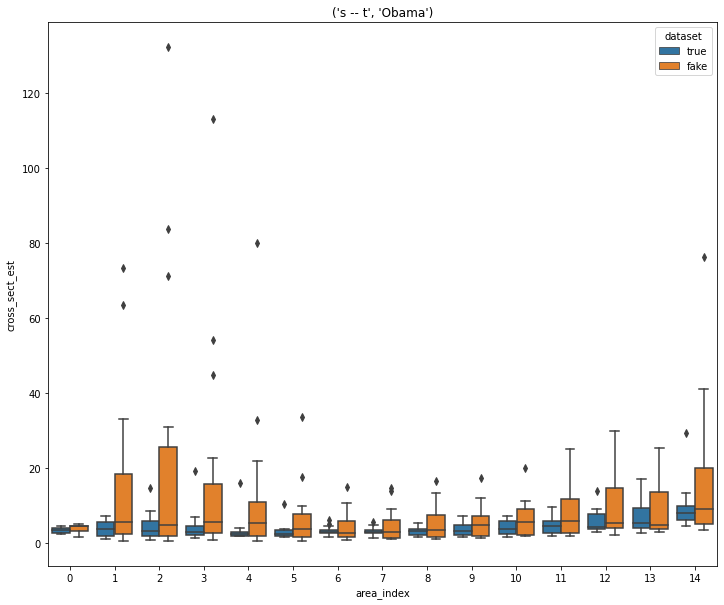

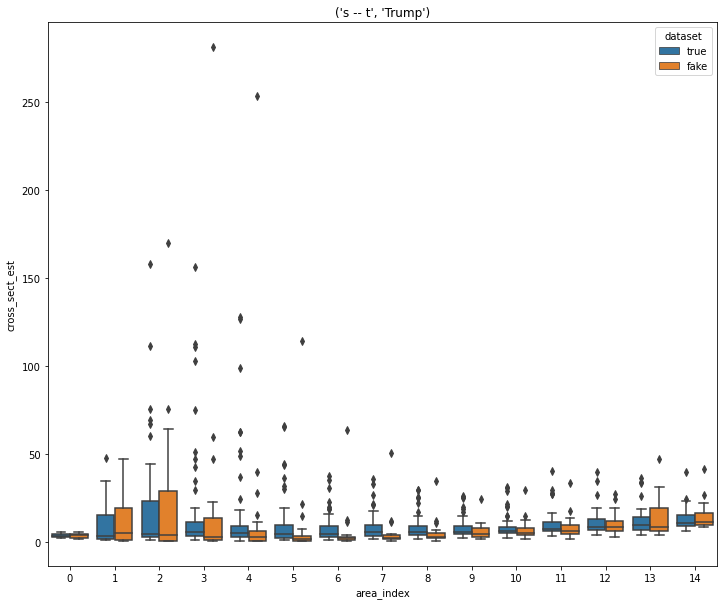

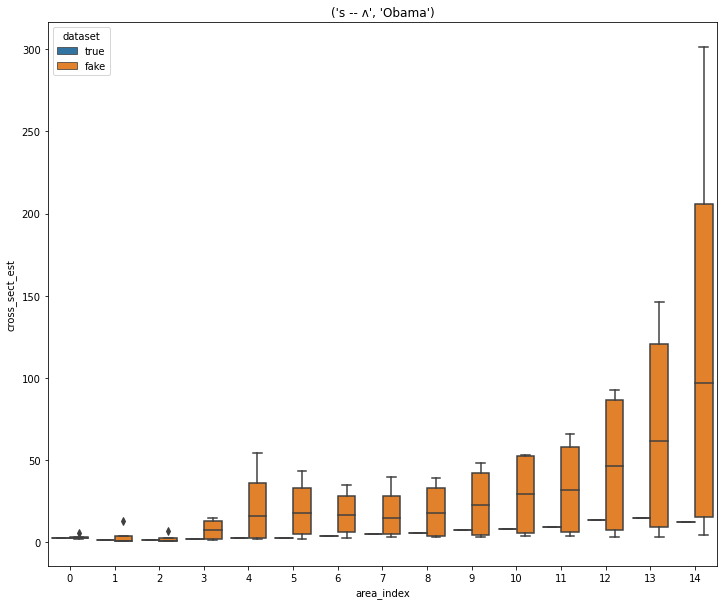

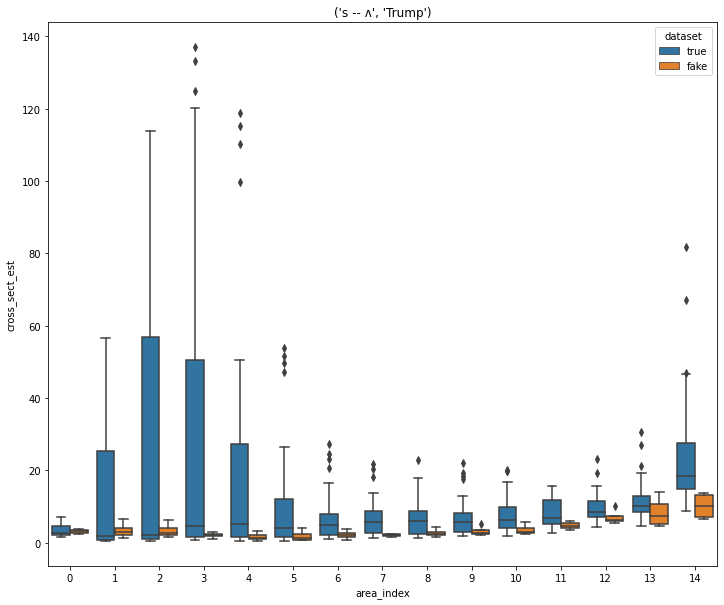

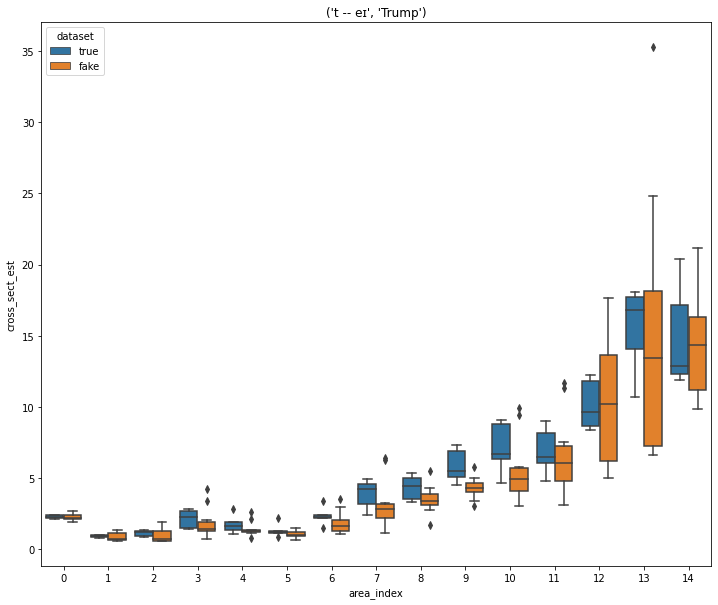

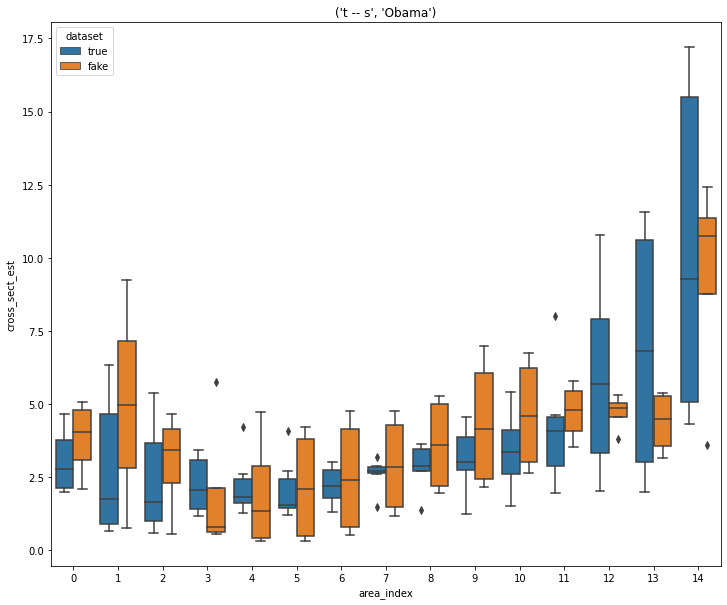

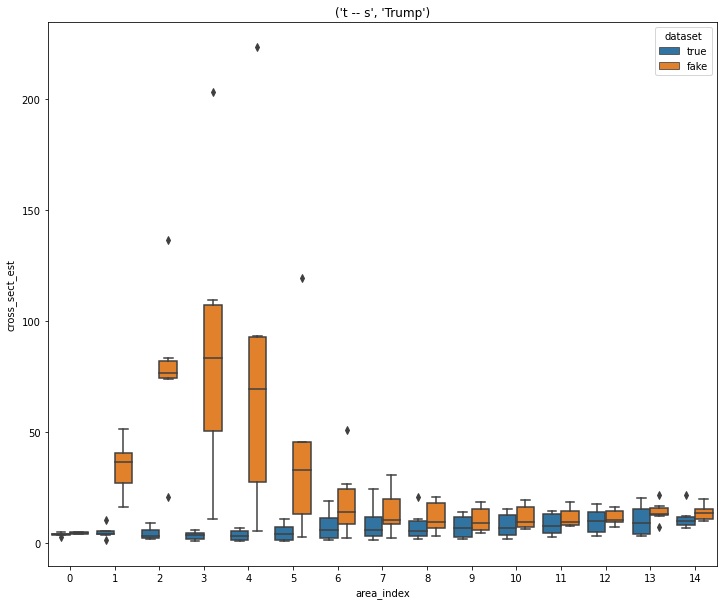

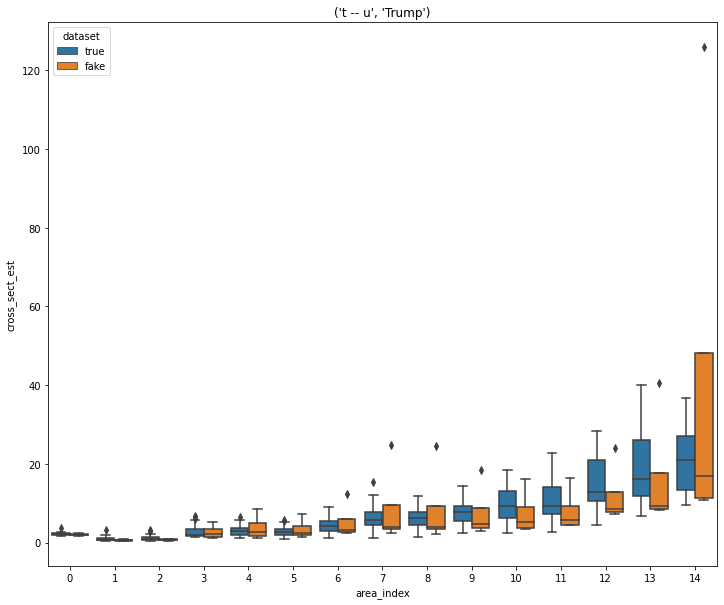

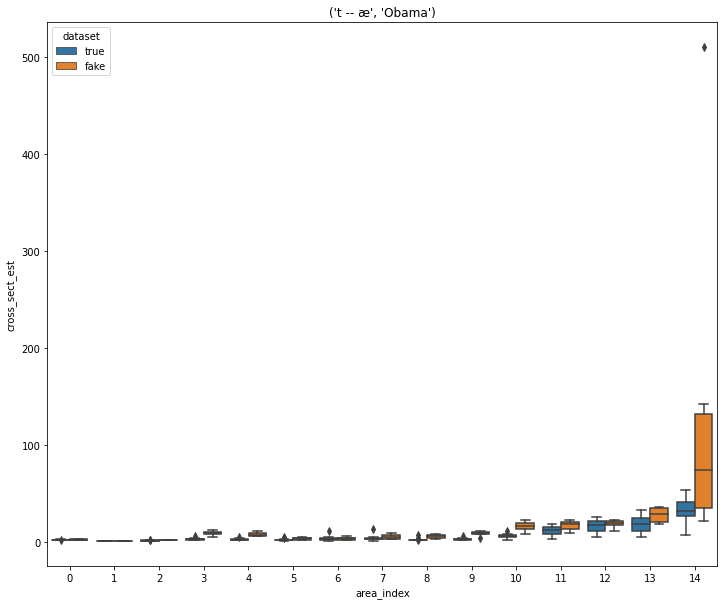

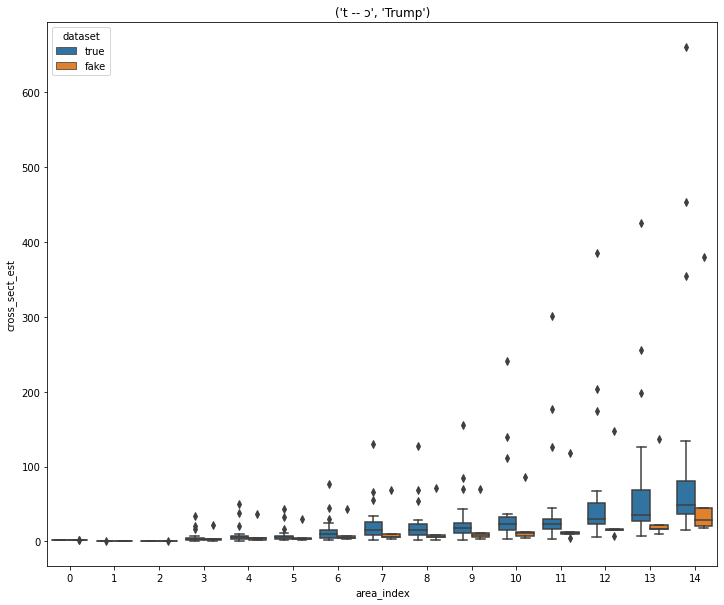

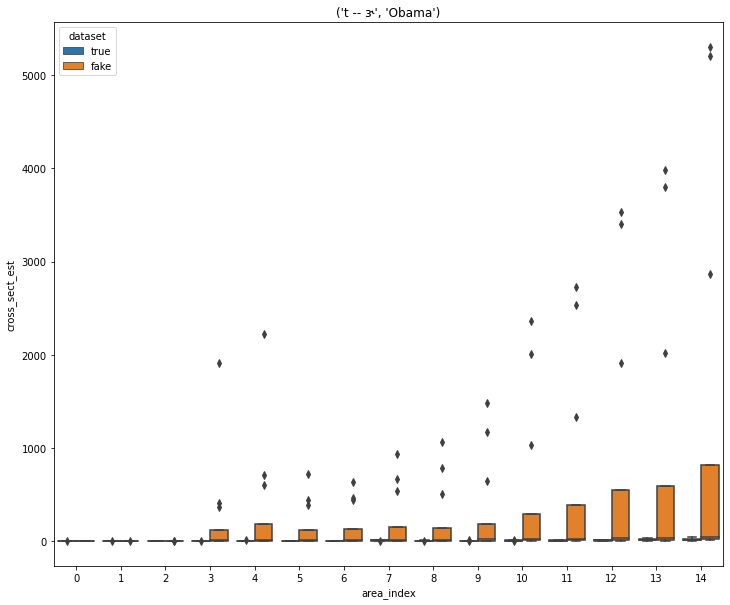

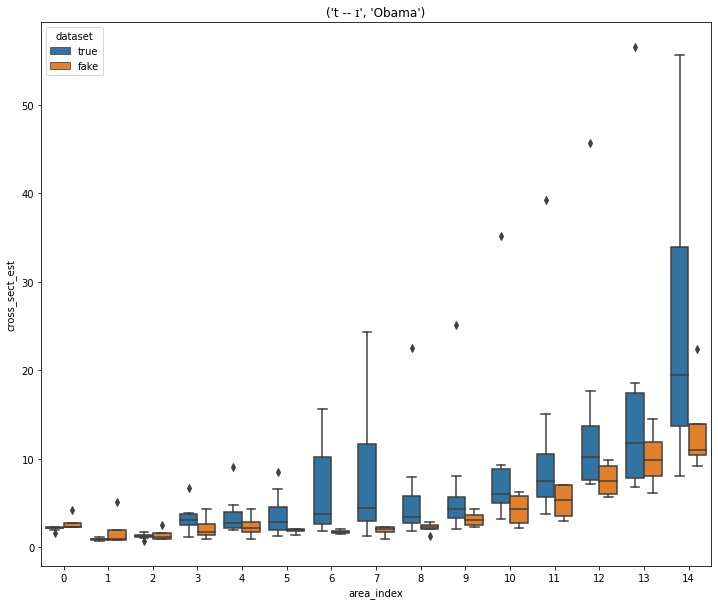

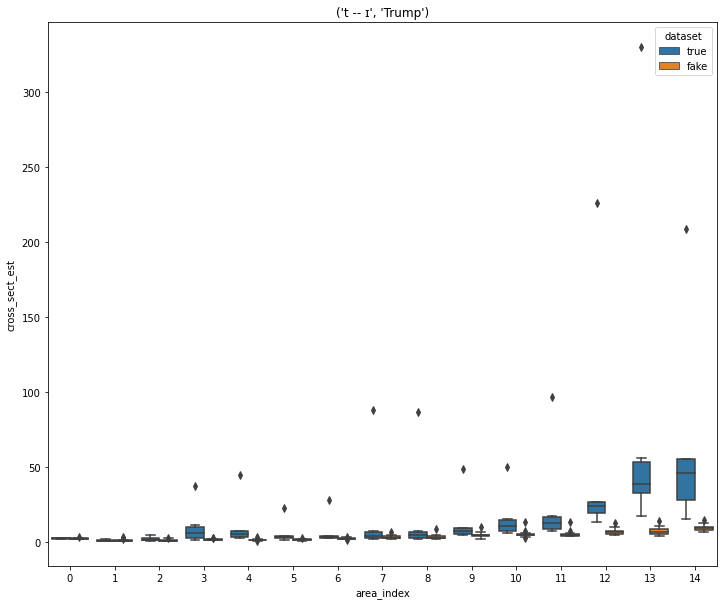

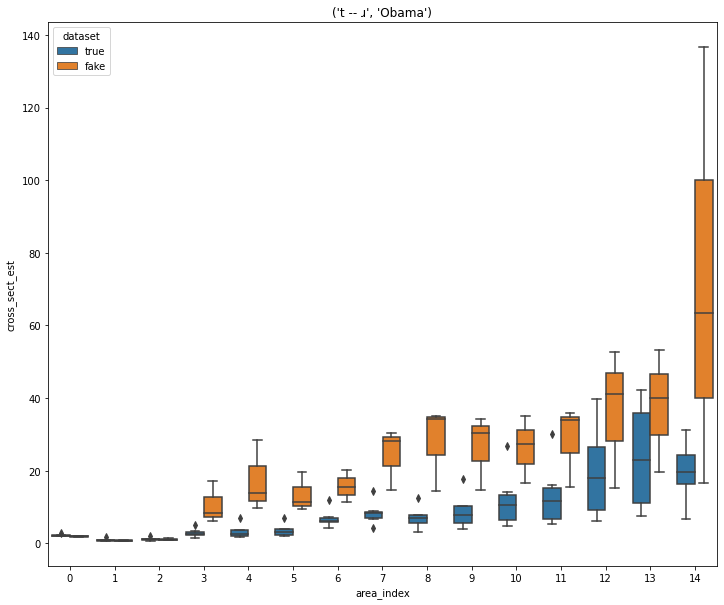

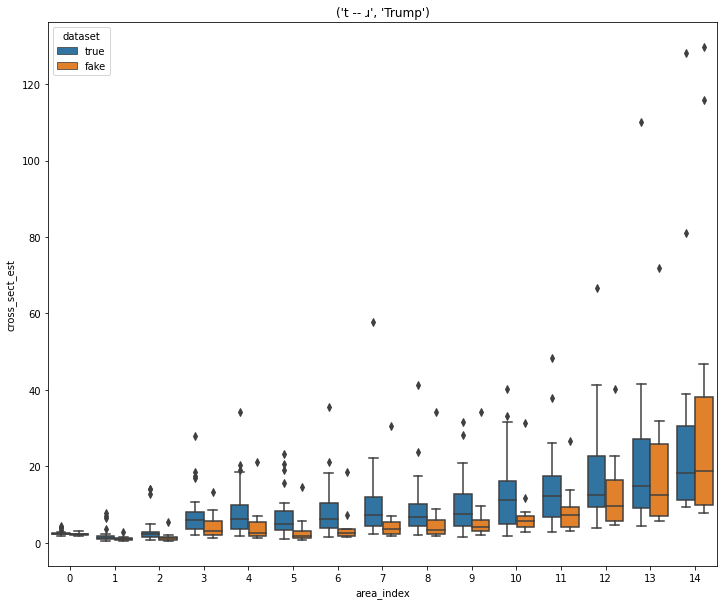

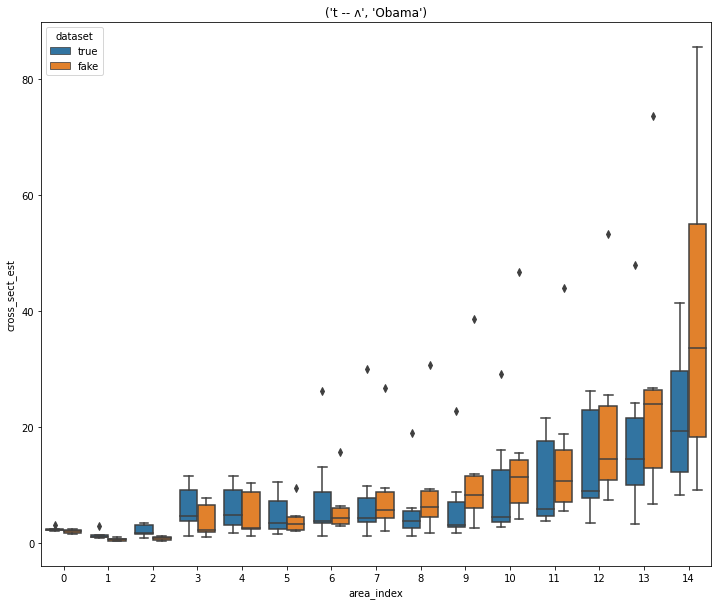

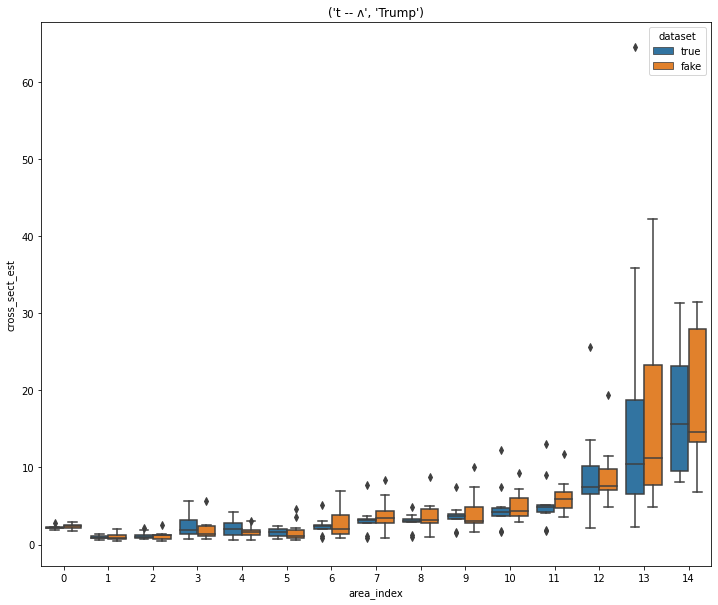

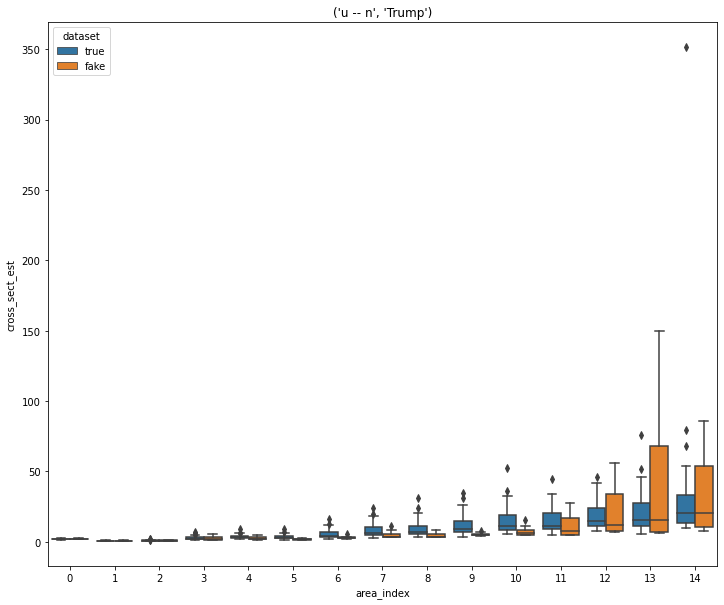

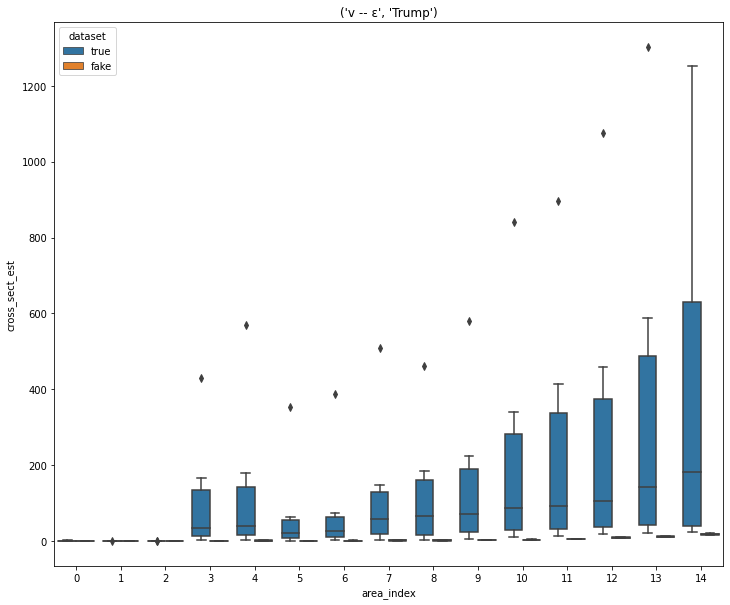

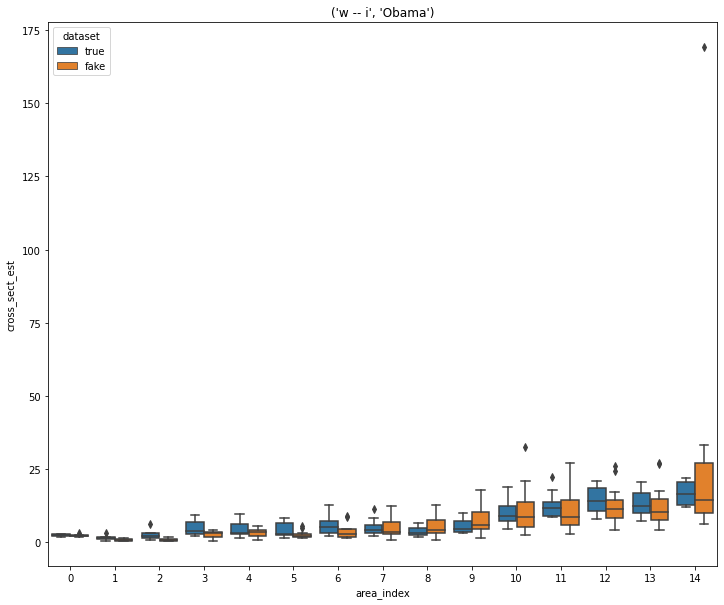

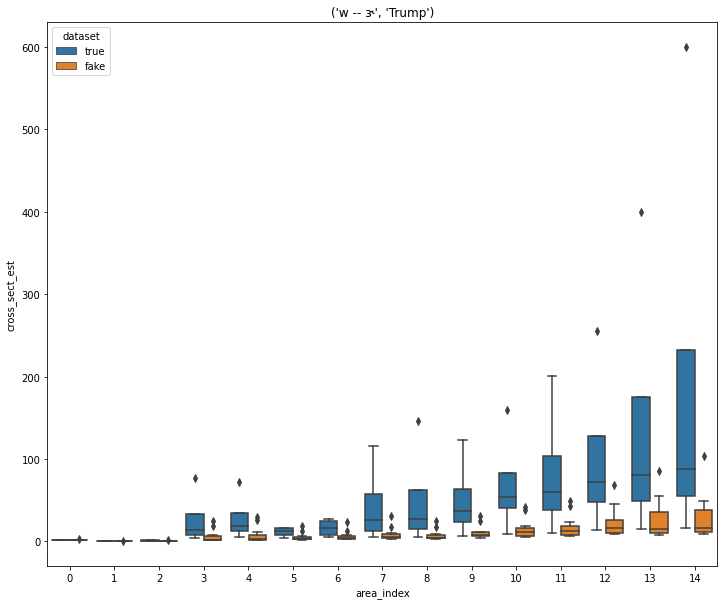

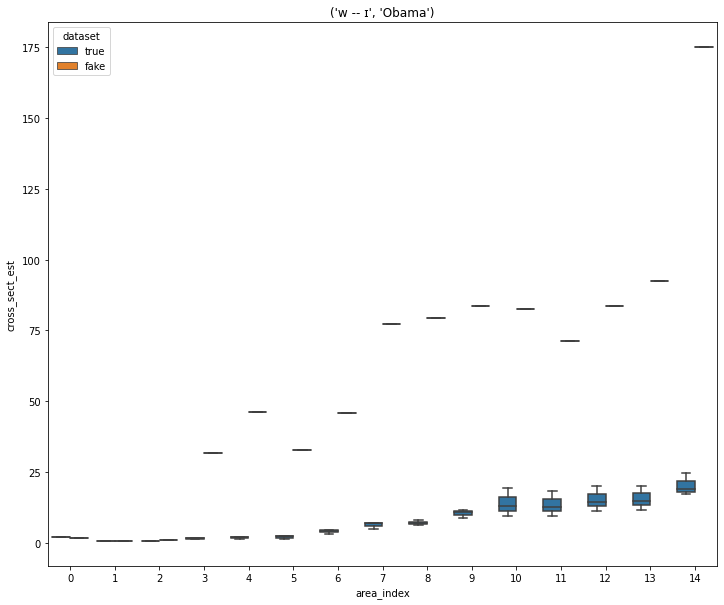

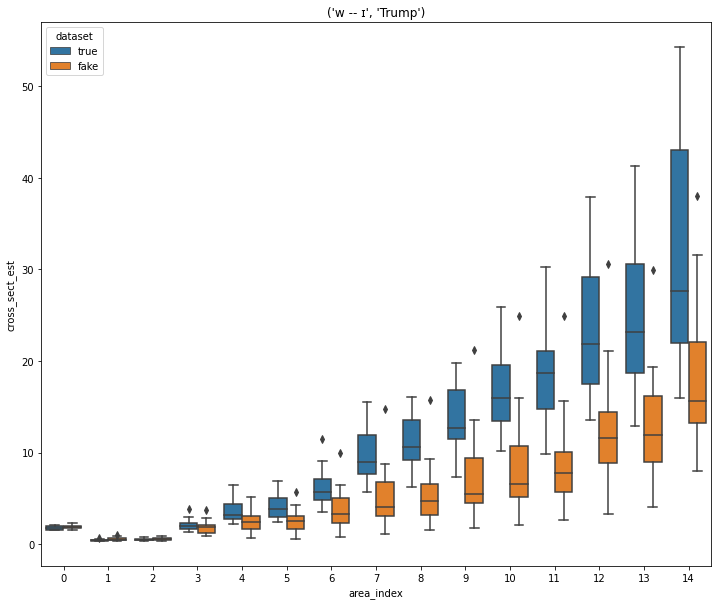

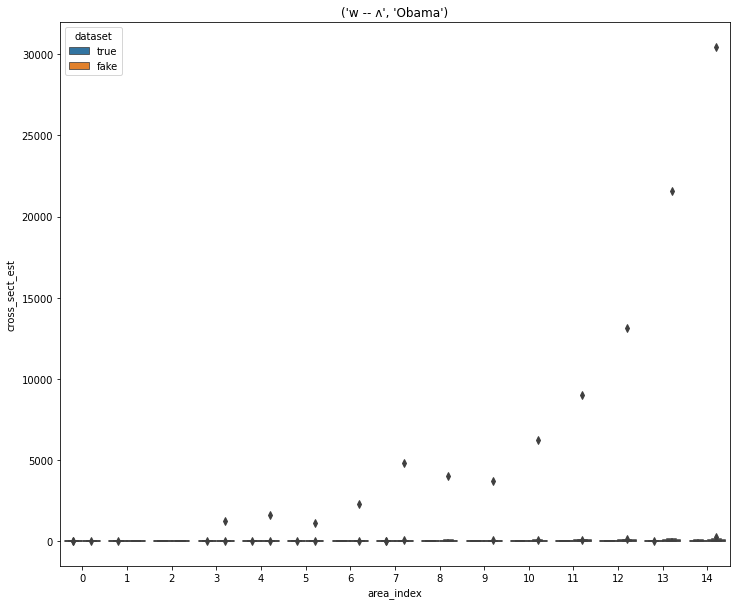

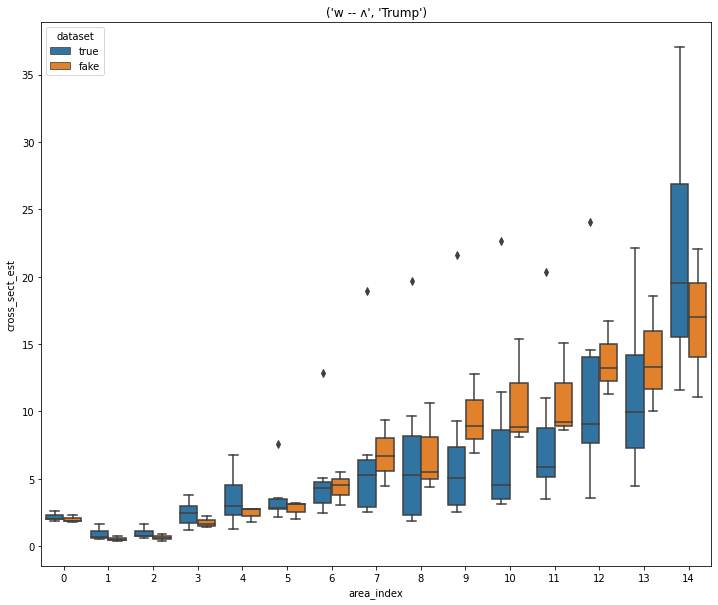

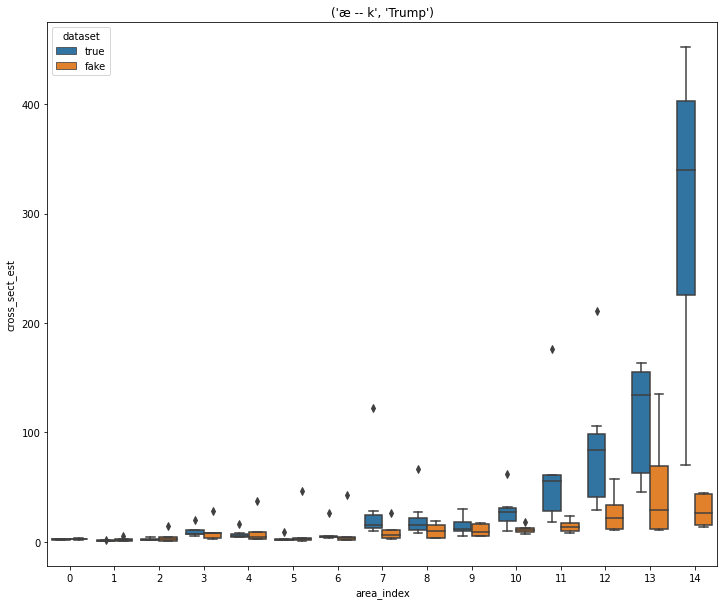

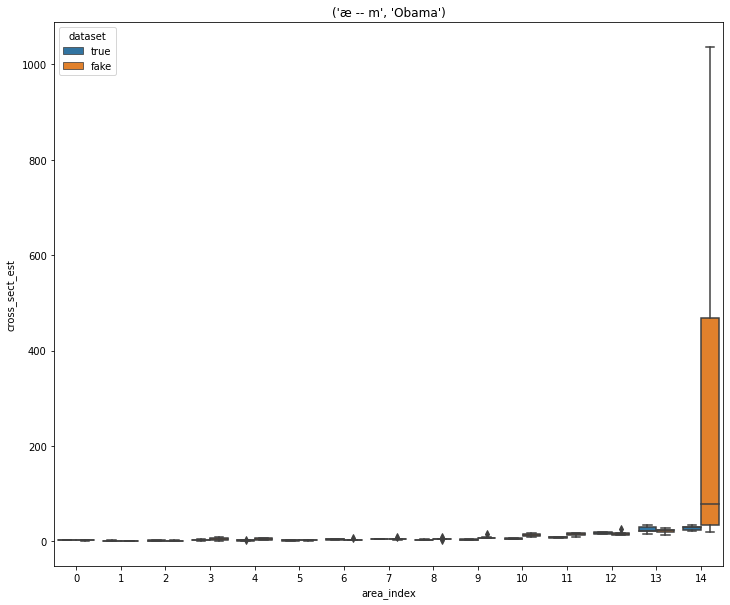

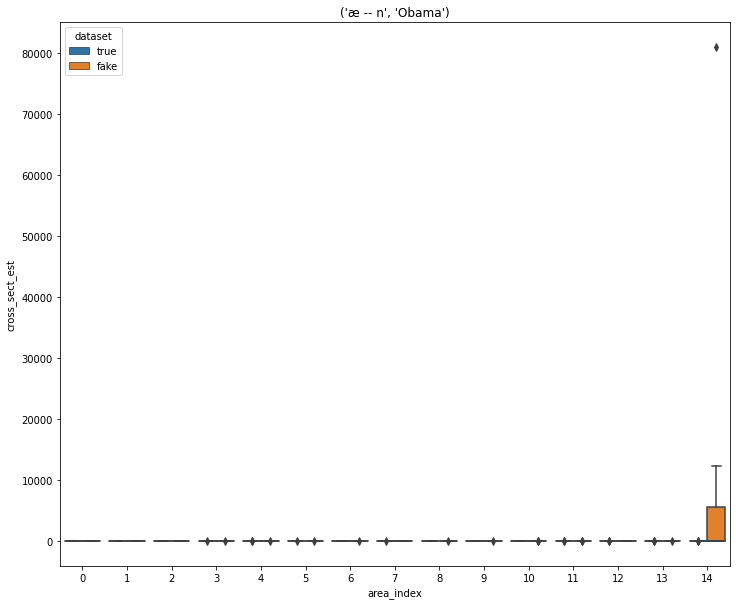

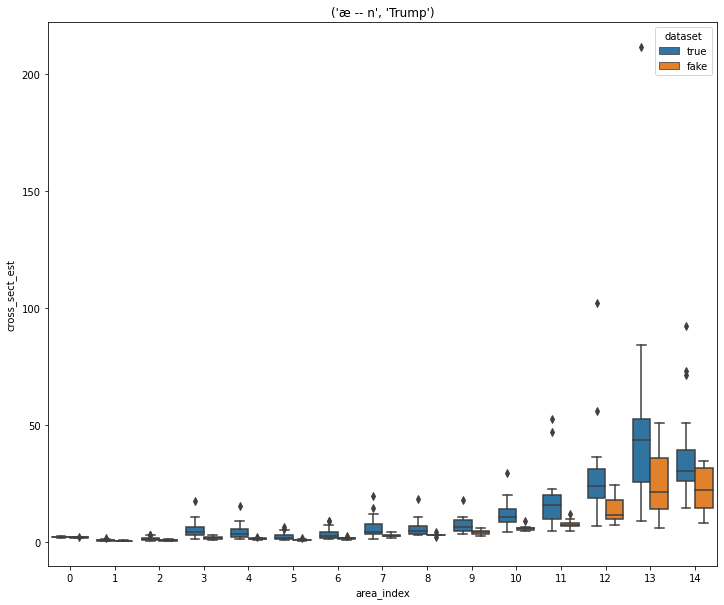

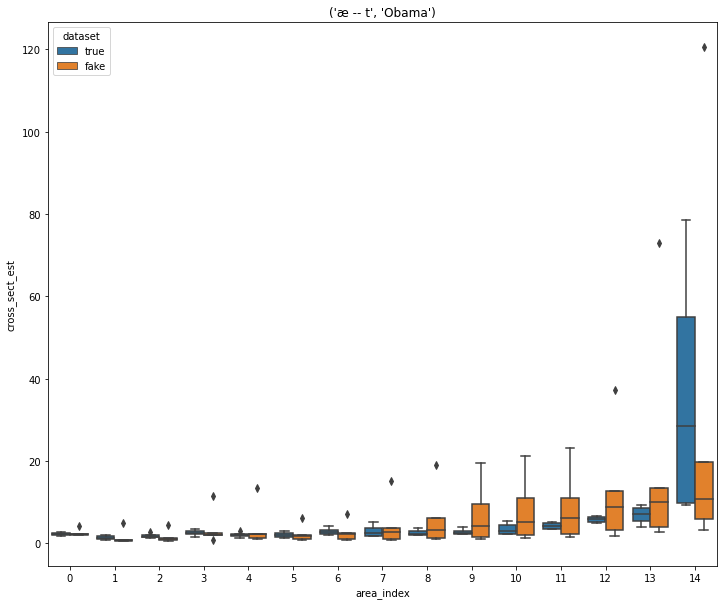

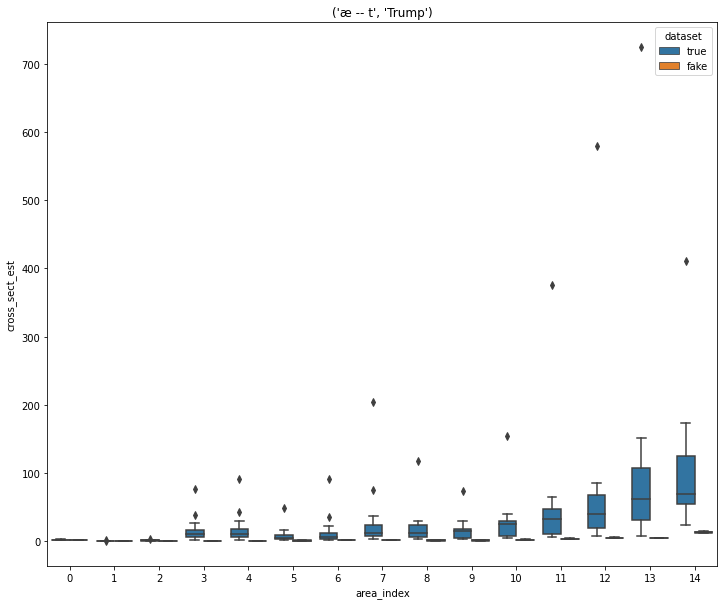

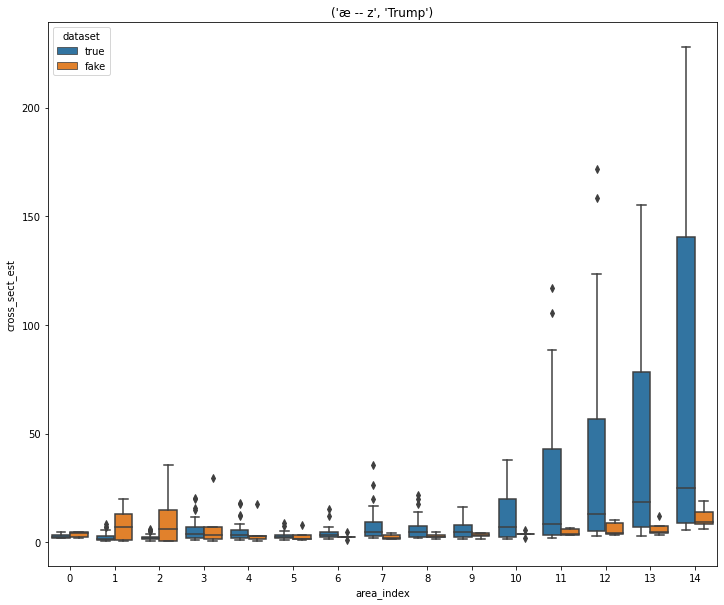

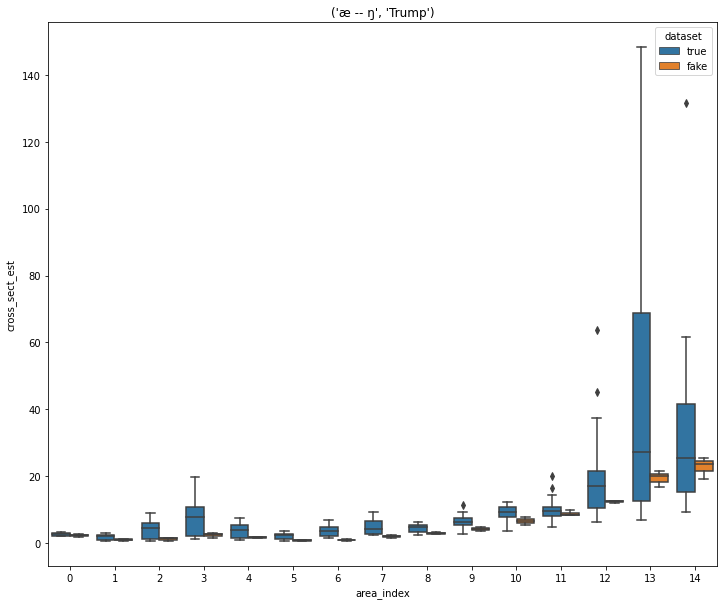

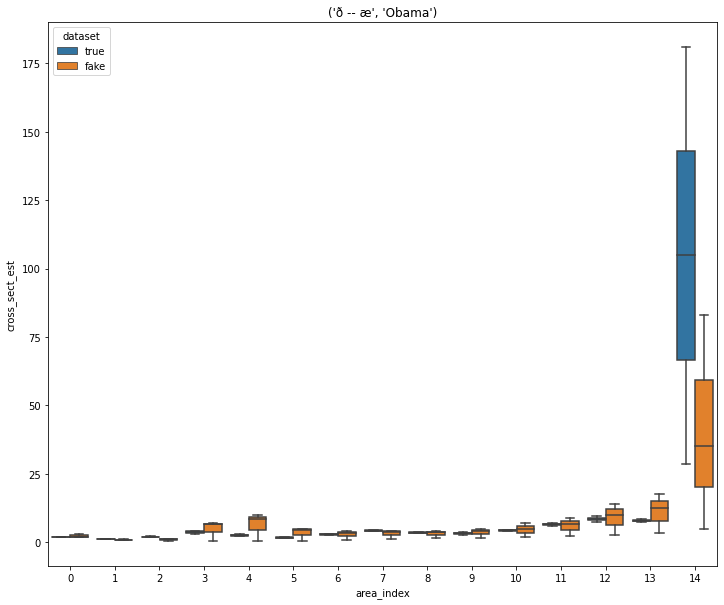

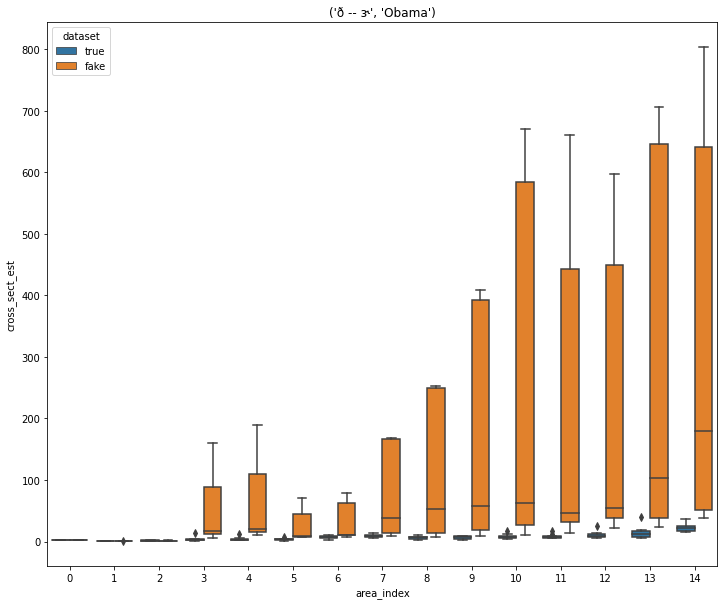

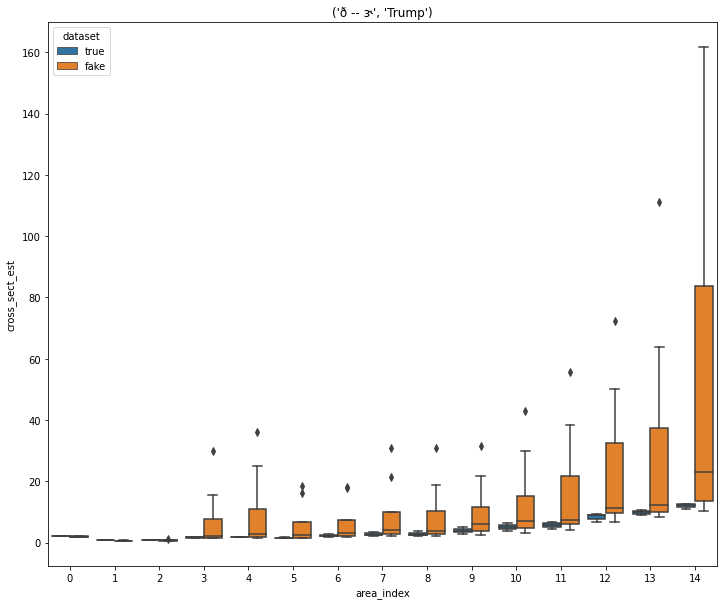

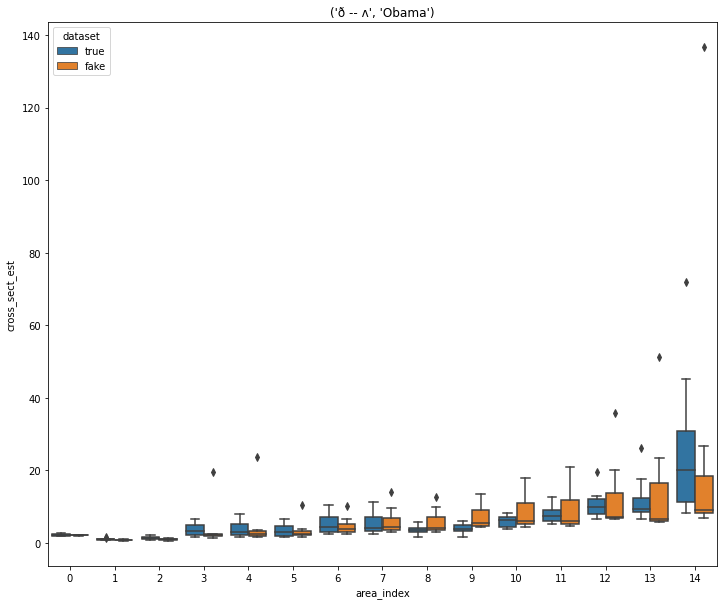

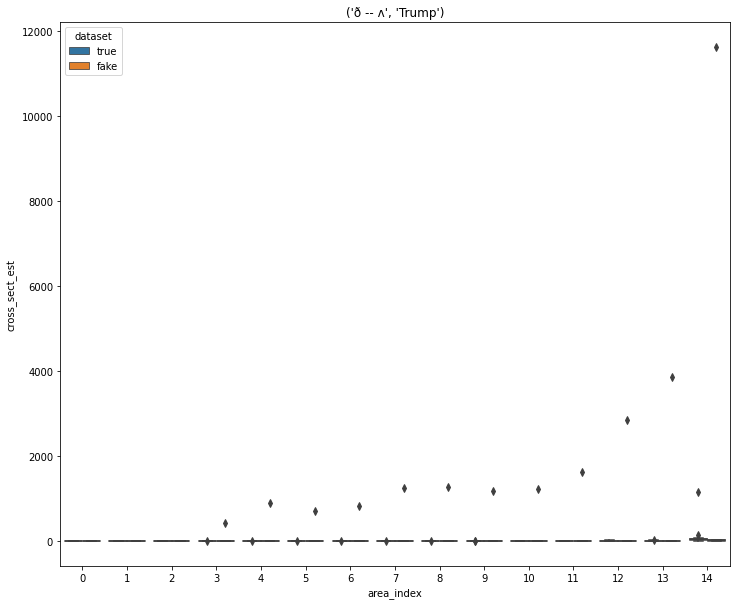

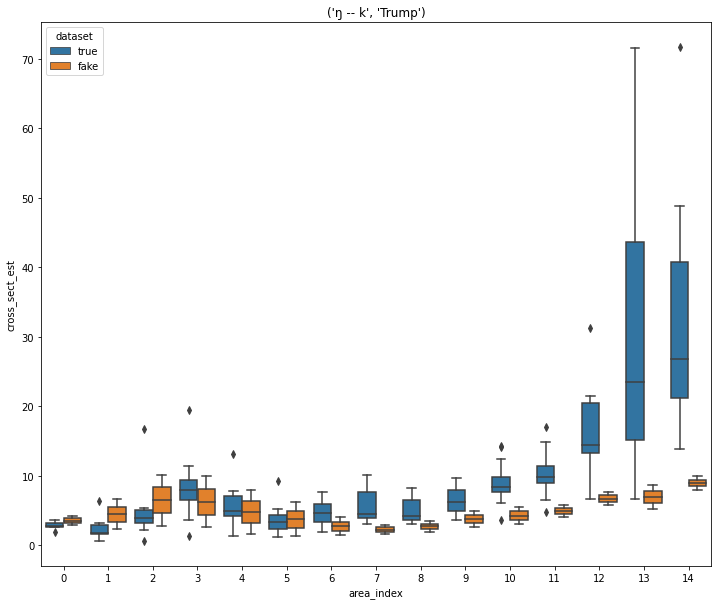

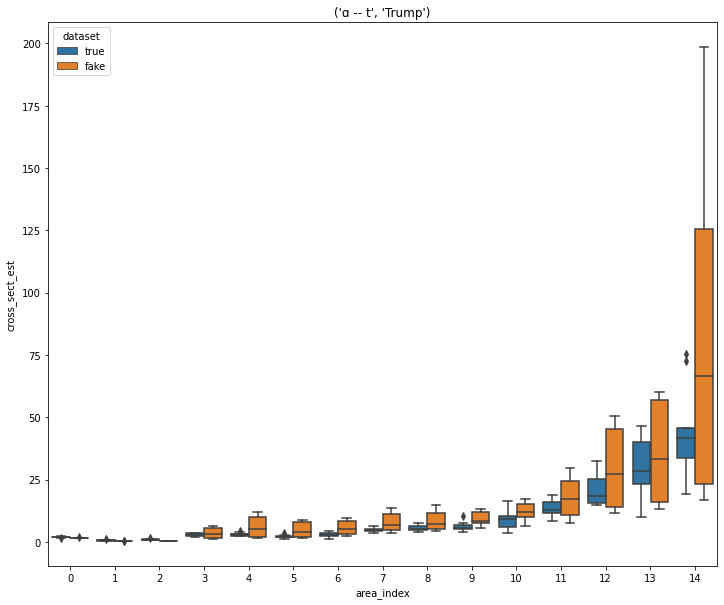

In [6]:
groups = df.groupby(['label', 'speaker_id'])

#filter out only sets of labels that have both true and fake examples
clean_groups = []


for key, grp in groups:
    if len(grp['dataset'].unique()) > 1:
            clean_groups.append((key, grp))

b_index = 0
for k, x in clean_groups:
    plt.figure(figsize=(12,10))
    plt.title(k)
    sns.boxplot(x='area_index', y='cross_sect_est', hue='dataset', data=x)
    
    if b_index < 100:
        b_index += 1
    else:
        break


## Looking at the variance in the true and fake 

In [14]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['lyrebird_fake']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating fake set')
df = df.drop(columns=['_id'])

df['dataset'] = 'fake'

#fix speaker labels
new_speaker_ids = []
for _, row in df.iterrows():
    if "obama" in row.filepath:
        new_speaker_ids.append('Obama')
    else:
        new_speaker_ids.append('Trump')

df['speaker_id'] = new_speaker_ids

#move to unique name
df_fake = df

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['lyrebird_true']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating true set')
df = df.drop(columns=['_id'])

df['dataset'] = 'true'

#fix speaker labels
new_speaker_ids = []
for _, row in df.iterrows():
    if "obama" in row.filepath:
        new_speaker_ids.append('Obama')
    else:
        new_speaker_ids.append('Trump')

df['speaker_id'] = new_speaker_ids

#move to unique name
df_true = df

df_var = pd.concat([df_true, df_fake])

Creating fake set
Creating true set


In [18]:
groups = df_var.groupby(['label', 'speaker_id'])

#filter out only sets of labels that have both true and fake examples
clean_groups = []

for key, grp in groups:
    if len(grp['dataset'].unique()) > 1:
            clean_groups.append((key, grp))
            
df_loc = clean_groups[0][1]
df_loc['variance'] = df_loc.apply(lambda row: np.var(row.cross_sect_est), axis=1)
df_loc[['cross_sect_est', 'variance', 'label', 'speaker_id', 'dataset']]

,cross_sect_est,variance,label,speaker_id,dataset
1952,"[1.8440678474032788, 0.6941699693015088, 0.973...",3603.932307,aɪ -- n,Trump,true
1953,"[2.1471214778994616, 0.7224410660696681, 0.952...",182.090740,aɪ -- n,Trump,true
1954,"[2.2961268261852483, 0.888139697435751, 1.3276...",182.040816,aɪ -- n,Trump,true
1955,"[2.10396708993796, 0.7934805134166867, 1.23544...",79.149405,aɪ -- n,Trump,true
1956,"[2.2165447378730825, 0.8201507052892948, 1.023...",47.834524,aɪ -- n,Trump,true
1273,"[2.2389571512267152, 0.6883582063292961, 0.592...",255.514292,aɪ -- n,Trump,fake
1274,"[2.344270195213592, 0.8145701632324915, 0.8209...",249.819321,aɪ -- n,Trump,fake
1275,"[2.3858266032863464, 0.7486759300991183, 0.880...",85.947233,aɪ -- n,Trump,fake
1276,"[2.091566227342454, 0.7294232488622503, 0.8923...",35.995833,aɪ -- n,Trump,fake
1277,"[2.2159298402698937, 0.7057452189234475, 0.926...",186.441899,aɪ -- n,Trump,fake


In [21]:
df_var['variance'] = df_var.apply(lambda row: np.var(row.cross_sect_est), axis=1)



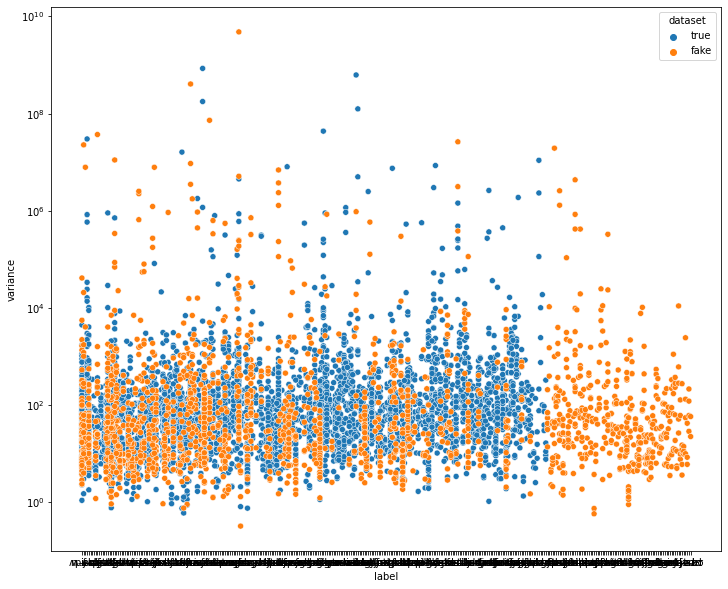

In [24]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='label', y='variance', data=df_var, hue='dataset')
plt.yscale('log')

In [30]:
df_explode

,cross_sect_est,label,filepath,speaker_id,start_bigram,end_bigram,window_start,window_end,window_index,sex,area_index,dataset
0,2.214984,ʌ -- n,/home/logan/SynologyDrive/Research/guesswho_ne...,Obama,61920,62880,62148,62713,0,f,0,true
1,1.065648,ʌ -- n,/home/logan/SynologyDrive/Research/guesswho_ne...,Obama,61920,62880,62148,62713,0,f,1,true
2,2.004144,ʌ -- n,/home/logan/SynologyDrive/Research/guesswho_ne...,Obama,61920,62880,62148,62713,0,f,2,true
3,9.998876,ʌ -- n,/home/logan/SynologyDrive/Research/guesswho_ne...,Obama,61920,62880,62148,62713,0,f,3,true
4,9.864797,ʌ -- n,/home/logan/SynologyDrive/Research/guesswho_ne...,Obama,61920,62880,62148,62713,0,f,4,true
...,...,...,...,...,...,...,...,...,...,...,...,...
92635,5.878258,ɝ -- k,/home/logan/SynologyDrive/Research/guesswho_ne...,Trump,453599,455199,456647,457212,3,f,10,fake
92636,5.029321,ɝ -- k,/home/logan/SynologyDrive/Research/guesswho_ne...,Trump,453599,455199,456647,457212,3,f,11,fake
92637,5.060802,ɝ -- k,/home/logan/SynologyDrive/Research/guesswho_ne...,Trump,453599,455199,456647,457212,3,f,12,fake
92638,5.533632,ɝ -- k,/home/logan/SynologyDrive/Research/guesswho_ne...,Trump,453599,455199,456647,457212,3,f,13,fake


In [85]:
#groupby bigram, index, true/fake
feature_groups = df_explode.groupby(['label', 'area_index'])

#get just the features present in both the fake and true datasets
df_comparable = feature_groups.filter(lambda row: row.dataset.nunique() > 1)

#set threshold at max value for organic
results = []
total_features = 0
for key, grp in feature_groups:
    #check if group contains both true and fake data
    if grp.dataset.nunique() > 1:
        #set threshold to max of true
        #display(grp)
        threshold = max(grp[grp.dataset == 'true'].cross_sect_est.values)
        
        #check if it perfectly divides our true and fake data
        division = grp[grp.dataset == 'fake'].cross_sect_est > threshold
        results.append([key[0], key[1], threshold, sum(division) / len(division)])
        
        #record that we were able to actually compare these features 
        total_features += 1

#Threshold sweeps to see which bigrams qualify
df_thres = pd.DataFrame(results, columns=['label', 'index', 'threshold', 'effectiveness'])
df_thres[df_thres.effectiveness >= 0.9].count()[0] / total_features

0.016666666666666666

Number of unique Bigrams in the full lyrebird set:  354
Number of unique Bigrams in the comparable set:  136
Number of unique Bigrams that would of been in the ideal feature set for this dataset:  136


In [90]:
ideal_label = df_thres.label.unique()
comparable_label = df_comparable.label.unique()

In [91]:
len(set(ideal_label) & set(comparable_label))

136

## Getting some high level stats for the paper

In [100]:
print("Number of unique bigrams found in the fakes: ", df_var[df_var.dataset=='fake'].label.nunique())
print("Number of total bigrams found in the fakes: ", df_var[df_var.dataset=='fake'].label.count())
print()
print("Number of unique bigrams found in the true: ", df_var[df_var.dataset=='true'].label.nunique())
print("Number of total bigrams found in the true: ", df_var[df_var.dataset=='true'].label.count())
print()
print("Number of unique Bigrams in the full lyrebird set: ", df_explode.label.nunique())
print("Number of unique Bigrams in the comparable set: ", df_comparable.label.nunique())
print("Number of unique Bigrams that would of been in the ideal feature set for this dataset: ", \
      df_thres.label.nunique())

Number of unique bigrams found in the fakes:  220
Number of total bigrams found in the fakes:  1914

Number of unique bigrams found in the true:  270
Number of total bigrams found in the true:  4262

Number of unique Bigrams in the full lyrebird set:  354
Number of unique Bigrams in the comparable set:  136
Number of unique Bigrams that would of been in the ideal feature set for this dataset:  136


In [107]:
df_explode.label.nunique()

354